Cosumnes Model 
@author: Andrew

In [1]:
# standard python utilities
import os
from os.path import join, exists, dirname, basename
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir

'C:\\Users\\ajcalder/Box/research_cosumnes/GWFlowModel'

In [3]:
flopy_dir = doc_dir+'/GitHub/flopy/'
if flopy_dir not in sys.path:
    sys.path.append(flopy_dir)
# sys.path
import flopy 

from importlib import reload
# importlib.reload
reload(flopy)

<module 'flopy' from 'C:\\Users\\ajcalder\\Documents/GitHub/flopy\\flopy\\__init__.py'>

In [4]:

# ss_bool = True # add steady state period
ss_bool = False # no steady state period

In [5]:

# Transient -> might want to think about making SP1 steady
# calibration run dates
# end_date = pd.to_datetime('2021-09-30')
# strt_date = pd.to_datetime('2018-10-01')

# scenario run_dates dry -> wet -> dry
# end_date = pd.to_datetime('2020-09-30')
# strt_date = pd.to_datetime('2015-10-01')
ss_strt = pd.to_datetime('2010-10-01')
end_date = pd.to_datetime('2020-09-30')
strt_date = pd.to_datetime('2014-10-01')


dates = pd.date_range(strt_date, end_date)

# The number of periods is the number of dates 
nper = len(dates) 
if ss_bool == True:
    nper += 1 

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper)
# steady state period can be 1 second
if ss_bool == True:
    perlen[0] = 1/86400  # first period is steady state, rest are transient

# Steady or transient periods
steady = np.zeros(nper)
if ss_bool == True:
    steady[0] = 1  # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()
# Reduce the number of timesteps to decrease run time
# nstp = np.ones(nper)*np.append(np.ones(1),1*np.ones(nper-1))
nstp = np.ones(nper)

In [6]:
# adjusters for boundary condition input
if ss_bool == False:
    time_tr0 = 0  
    nper_tr = nper 
else:
    time_tr0 = 1
    nper_tr = nper-1


In [7]:
nrow=100
ncol=230
delr=200
delc=200
rotation=52.9

# The number of layers should be 1 for the Mehrten formation, 1 for the laguna plus the number of TPROGS layers,
# where the Laguna formation will be clipped by the TPROGS layers
# max_num_layers =148 # based on thickness from -6m (1 m below DEM min) to -80m
# upscale = 8
# num_tprogs = int(max_num_layers/upscale)
# tprog_thick = max_num_layers*0.5/num_tprogs

# elevation minimum is -1.2 m so have tprogs start at -2 to leave room for filler layer
tprog_strt = -2
# only need tprogs data nearer surface river-aquifer interaction
tprog_total = 64 #12 
upscale = 8 # from usual 0.5m
tprog_thick = 0.5*upscale
num_tprogs = int(tprog_total/tprog_thick)

# num_tprogs = 0
# tprog_thick = 0

num_leveling_layers = 1 # layers to create the upscaled unsaturated zone
nlay = 2 + num_leveling_layers + num_tprogs

# There is essentially no difference bewtween WGS84 and NAD83 for UTM Zone 10N
# proj4_str='EPSG:26910'
proj4_str='+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '
print('TPROGs layers', num_tprogs)

TPROGs layers 16


In [8]:
from flopy.utils.geometry import Polygon, LineString, Point
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')

# Need to check this when changing model domains
xul, yul = list(m_domain.geometry.values[0].exterior.coords)[1]
list(m_domain.geometry.values[0].exterior.coords)
# m_domain.geometry.values[0].exterior

[(645500.0, 4227700.0),
 (629548.3214234954, 4239764.159754906),
 (657295.8888597784, 4276453.020480867),
 (673247.567436283, 4264388.860725961),
 (645500.0, 4227700.0)]

## Individual Users may change loadpath 
The default loadpath is set to an existing external hard drive for Andrew as F://
If the script doesn't find an external harddrive F:// then it will default to the C:// Drive in WRDAPP

In [9]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/Regional/'
model_ws = loadpth+'historical_simple_geology'

In [10]:
# switch to modflow nwt to enable option bloack for use in owhm
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf-owhm.exe', 
                          version = 'mfnwt', model_ws=model_ws)
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
#                           version = 'mf2005', model_ws=model_ws)
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)


In [11]:

# m.modelgrid.set_coord_info(xoff=xll, yoff=yll, proj4='EPSG:32610', angrot=rogation)
mg = m.modelgrid
# Write model grid to shapefile for later use
# mg.write_shapefile(gwfm_dir+'/DIS_data/grid/grid.shp', epsg = '32610')


In [12]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')


In [13]:
grid_elev = gpd.read_file(join(gwfm_dir,'DIS_data','grid_elevation_m_statistics.shp'))

In [14]:
# get exterior polyline of model grid
grid_bnd = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union.exterior], crs=grid_p.crs)
# find cells that construct the model boundary
bnd_cells = gpd.sjoin(grid_p, grid_bnd)
bnd_cells = bnd_cells[['row','column']] - 1
bnd_cells['grid_id'] = np.arange(0,len(bnd_cells))
bnd_rows, bnd_cols = bnd_cells.row.values, bnd_cells.column.values

<Axes: >

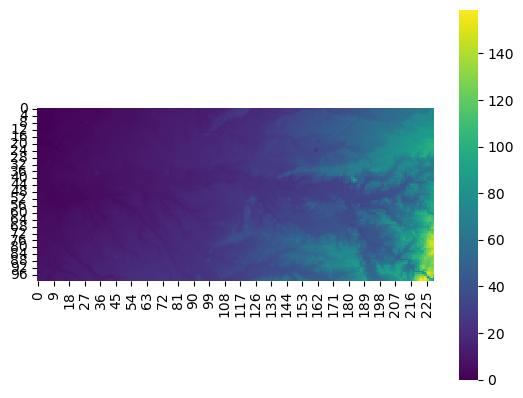

In [15]:
# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_nearest.tsv', delimiter = '\t')
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')

import seaborn as sns
sns.heatmap(dem_data, cmap = 'viridis', vmin = 0,square=True)

# Capture cross section of deeper geology

In [16]:
# Pre-cretaceous metamorphic rocks - (variable thickness 200-500 ft thick)
# Ione formation (200 ft thick)
# Valley Springs formation (300 ft thick)
# Mehrten Formation (100 ft thick to 300 ft thick) (1-2 deg dip)
# Laguna Formation (less than 100 ft to between 200-300 ft thick) (less than 1 deg dip)
# upper formation (informed by well logs) (100 ft)

## Need to adjust for change in model grid, based on Michigan Bar previously, maybe also look at effect of model domain angle vs cross section angle

In [17]:
# The stream gage at michigan bar is now 13 columns in from the boundary
# mehrtenbound

# Cross section E appears to have an angle of 0 compared to the model domain,

C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


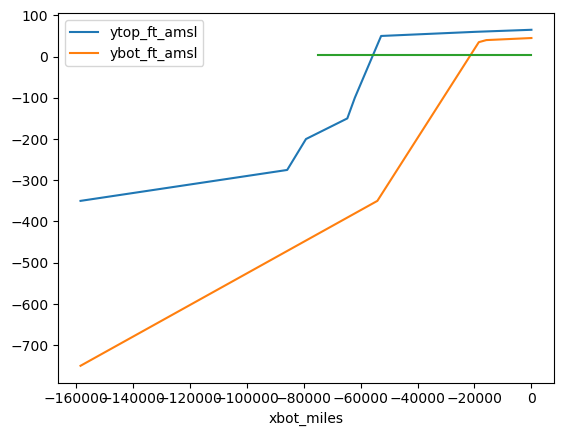

In [18]:
# # columns are xtop_miles, ytop_ft_amsl, xbot_miles, ytop_ft_amsl
# # XS upper bound should be at Michigan bar which is between Jackson road and Sacramento-Amador county line split
# # Mile 36 is approximately where Michigan bar aligns with the cross section
MB_XS_mile = 36
mehrtenbound = pd.read_csv(gwfm_dir+'/DIS_data/Mehrten_boundary_x_y.csv', parse_dates = False, 
                index_col = False, sep = ',', header = 'infer')
# Convert miles to feet and sets x value based on location of Michigan bar
# 0 is michigan bar and each major change in geologic dip is based on distance from Michigan Bar
mehrtenbound.xtop_miles = -5280*(MB_XS_mile - mehrtenbound.xtop_miles)
mehrtenbound.xbot_miles = -5280*(MB_XS_mile - mehrtenbound.xbot_miles)
# No flod boundary based on the original coordinates of the bottom of the Mehrten formation
mehrtenbound.noflow_x_miles = -5280*(MB_XS_mile - mehrtenbound.noflow_x_miles)

# East of mile 32 the entire vertical cross section, including up to the near entire surface
# is composed of old geologic formations that are not water bearing
volcanic_bound = (MB_XS_mile - 32)*-5280
# noflow_ind = int((1-(volcanic_bound/sumx))*ncol)

# Plot the x and y values
fig, ax = plt.subplots(1, 1)
mehrtenbound.plot(x = 'xtop_miles', y = 'ytop_ft_amsl', ax = ax)
mehrtenbound.plot(x = 'xbot_miles', y = 'ybot_ft_amsl', ax = ax)
plt.plot(-100*3.28*np.arange(0,len(dis.top[40,:])), np.flip(3.28*dis.top[40,:]))
# print(mehrtenbound)

In [19]:

def xy_to_botm(xbound_ft, ybound_ft, nspace,ntransversespace):
    laybotm = np.zeros((ntransversespace, nspace))
    # Nspace will be either nrow or ncol depending model direction
    # ntransversespace is the opposite of nspace (ie nrow if nspace is ncol)
    # Calculate the distance between each major change in dip
    dx = np.diff(xbound_ft)
    # Scale by the total distance across the coordinates to get percentages
    sumx = np.sum(dx)
    dx /= sumx
    # Multiply the number of columns by the percent of columns in each section of constant dip
    dx *= nspace
    # Round the number of columns to allow proper use for indexing
    nx = np.round(dx).astype(int)
    # Fix any discrepancy in number of columns due to issues with rouding the percentages of columns
    # Add a column to the last set of columns because there is already uncertainty at the deeper end
    while(np.sum(nx)-nspace !=0):
        if np.sum(nx)-nspace <0:
            nx[-1] += 1
        elif np.sum(nx)-nspace >0:
            nx[-1] -= 1
    sum(nx)

    # Now split the coordinates into downsized coordinates in between each major change in dip
    k = 0
    for i in np.arange(0,len(nx)):
        for j in np.arange(0,ntransversespace):
            laybotm[j, k:k+nx[i]] = np.arange(ybound_ft[i],ybound_ft[i+1], -(ybound_ft[i]-ybound_ft[i+1])/nx[i])
        k += nx[i]
    return(laybotm)

In [20]:
# X (east -west) and y (up-down vertical) of major dip changes for Mehrten Formation top boundary

mehrten_top = xy_to_botm(mehrtenbound.xtop_miles,mehrtenbound.ytop_ft_amsl, ncol, nrow)
# X (east -west) and y (up-down vertical) of major dip changes for Mehrten Formation bottom boundary
# drop na is because there are less values to mark changes in the bottom than top boundary
mehrten_bottom = xy_to_botm(mehrtenbound.xbot_miles.dropna(),mehrtenbound.ybot_ft_amsl.dropna(), ncol, nrow)

# Original x,y data for Mehrten bottom boundary to represent the noflow bounds
no_flow_bound = xy_to_botm(mehrtenbound.noflow_x_miles.dropna(), mehrtenbound.noflow_y_ft_amsl.dropna(),ncol,nrow)

In [21]:
botm = np.zeros((nlay, nrow, ncol))
# Convert units from ft to meters and flip to match direction
botm[-2,:,:] = np.flip(mehrten_top/3.28)
botm[-1,:,:] = np.flip(mehrten_bottom/3.28)
no_flow_bound = np.flip(no_flow_bound/3.28)


## Adjustment to bottom boundary to ensure sufficient top layer thickness for the TPROGS model
Although the bottom boundaries are being artifically lowered to allow for sufficient layer thickness, this will be corrected when ibound is implemented based on where the actual bottom boundary is and where there is high elevations based on likelihood to be volcanics geology.  
TPROGs extends from -80 to 80. The lowest point in the DEM is -5m, we should drop more than 1m below this to ensure adequate thickness for calculations. This leaves -6 m to -80 for TPROGs with standard upscaling, so 148 layers

In [22]:
# The TPROGS model is 100m thick with some of it above the land surface
# to be safe, there should be at least 50 meters below ground surface to the bottom boundary

# Create 4 layers representing the upscaled "unsaturated" zone 
# ensures there is at least 1 m for each upscaled layer and rounded to create a clean boundary with the TPROGS data
# leveling_layer_bottom = np.round(np.min(dem_data) - num_leveling_layers*1) - 1
# minimum thickness between top layer and Laguna?
leveling_layer_thickness = -10 # (dem_data - leveling_layer_bottom)/num_leveling_layers
botm[num_leveling_layers-1,:,:] = tprog_strt
for i in np.arange(num_leveling_layers-1,0,-1):
    botm[i-1,:,:] = botm[i,:,:] + leveling_layer_thickness
    
# Create TPROGS layers from top down
for i in np.arange(num_leveling_layers, num_leveling_layers + num_tprogs):
    botm[i,:,:] = botm[i-1,:,:] -tprog_thick
    
# Thickness to give to bottom layers below the TPROGS layers just to provide adequate spacing,
# this will be corrected by changing the geology in the layers above to account for what is actually in
# the Mehrten and what is in the Laguna formations, thickness of 5 also prevents any messy overlap
thickness_to_skip =10
# # Find where top boundary of Mehrten Formation rises within 10 meters of the top layer (10m for sufficient layer thickness)
bot3ind = np.min(np.where(botm[-2,:,:]>botm[-3,:,:]- thickness_to_skip)[1])

# # Where the top boundary of Mehrten was within 10 meters of the top layer 
# # set it equal to top layer elevation minus 10 for sufficient layer thickness
botm[-2,:,bot3ind:] = botm[-3,0,bot3ind]- thickness_to_skip
# # Repeat steps above for bottom of Mehrten formation with the top of the Mehrten formation
bot3ind = np.min(np.where(botm[-1,0,:]>botm[-2,0,:]- thickness_to_skip))
botm[-1,:,bot3ind:] = botm[-2,0,bot3ind]-thickness_to_skip

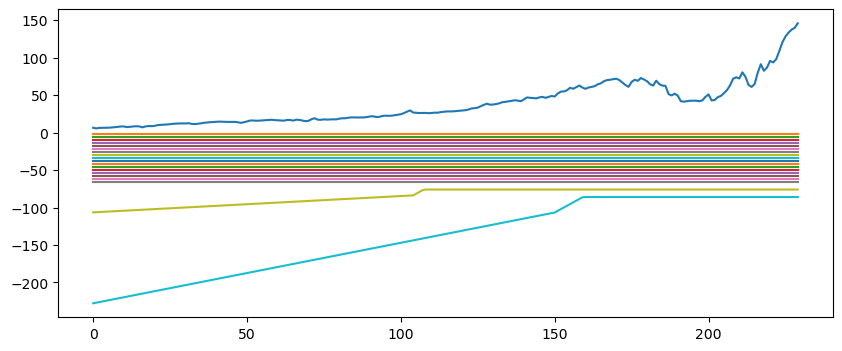

In [23]:
# when you apply the 1/200 aspect the dips in the cell seem a lot less severe, so may just leave the layering as is
# for now with 4 layers representing the unsaturated zone
fig,ax = plt.subplots(figsize = (10,4))
# ax.set_aspect(aspect = 1/10)
plotrow = 80
plt.plot(dem_data[plotrow,:])

for i in np.arange(0,nlay):
    plt.plot(botm[i,plotrow,:])

In [24]:
# Set the elevation of the top layer based on the DEM
m.dis.top = dem_data
# Bottom of model based on geology
m.dis.botm = botm
chk = dis.check()
chk.summary_array

# join top and botm for easier array referencing for elevations
top_botm = np.zeros((m.dis.nlay+1,m.dis.nrow,m.dis.ncol))
top_botm[0,:,:] = m.dis.top.array
top_botm[1:,:,:] = m.dis.botm.array



DIS PACKAGE DATA VALIDATION:
  5 Errors:
    5 instances of thin cells (less than checker threshold of 1.0)

  Checks that passed:
    zero or negative thickness
    nan values in top array
    nan values in bottom array



## Complex ibound

### Define no flow cells based on elevation, informed by DWR cross sections and geologic maps of volcanic geology fingers leaving the mountains
In general, the location of Michigan Bar is near the boundary where there is total volcanics to majority alluvium. However there is a major finger North and South of the Cosumnes River of andesititc conglomerate, sandstone, breccia

In [25]:
# slope doesn't provide clear guidance on differentiating foothills
# slope_gdf = gpd.read_file(join(gwfm_dir, 'DIS_data', 'grid_zonal_stats','slope_percentage_statistics.shp'))

# slope = np.zeros((nrow,ncol))
# slope[slope_gdf.row-1, slope_gdf.column-1] = slope_gdf['mean']

# plt.imshow(slope>8)

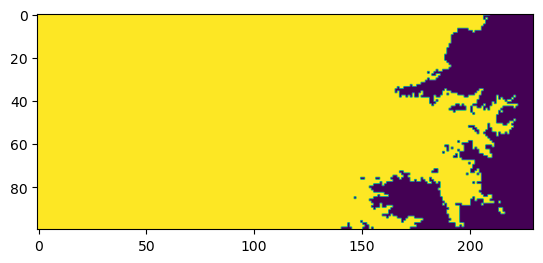

In [26]:
# Simplified ibound, only no flow cell if it is below the bottom of the Mehrten Formation
# Specify no flow boundary based on rough approx of geology (upper basin volcanics)
ibound = np.ones([nlay, nrow,ncol])


cutoff_elev = 56
ibound = ibound*(dem_data<cutoff_elev)

plt.imshow(ibound[0,:,:])

### Create a line bounding the noflow region to set the specified head boundary

In [27]:
import pprint
from rasterio.features import shapes, rasterize

# The function shapes from rasterio requires uint8 format
ibound_line = ibound.astype(rasterio.uint8)
out = shapes(ibound_line,connectivity = 8)
alldata = list(out)

# maxl = 0
maxl = np.zeros(len(alldata))
for i in np.arange(0,len(alldata)):
    maxl[i] = len(alldata[i][0].get('coordinates')[0])
#     if len(alldata[i][0].get('coordinates')[0])>maxl:
#         maxl = len(alldata[i][0].get('coordinates')[0])
#         ind = i
# select the two longest linestring indexes (1st will be chunk down of divide (lower elevation) 2nd will chunk above (high elev))
maxl1, maxl2 = np.where(maxl>np.mean(maxl))[0]
print(maxl[maxl>np.mean(maxl)])

[533. 495.]


In [28]:
temp = alldata[maxl2][0].get('coordinates')[0]
tl = LineString(temp)
tl

In [29]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)

# Get the constant head or general head boundary after the no flow cells
linerast = rasterio.features.rasterize([tl], out_shape = np.array((nrow,ncol)))
# remove far east bound line
linerast[:,ncol-1] = 0
fix_bound = np.min(np.argwhere(linerast[0,:]==1))
linerast[0,:] = 0
linerast[0,fix_bound]
np.shape(linerast)

# ibound[0,linerast==1] = -1

(100, 230)

In [30]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)
tu = unary_union(tl)
poly = list(polygonize(tu))
# Set the polygon/raster for the top layer, no buffer needed
poly0 = poly[0].buffer(distance = 0)
polyrast0 = rasterio.features.rasterize([poly0], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the top layer, slight buffer needed to expand geologic formation outward with depth as 
# naturally occurs
poly1 = poly[0].buffer(distance = 13)
polyrast1 = rasterio.features.rasterize([poly1], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the bottom layer, largest buffer needed
poly2 = poly[0].buffer(distance = 17)
polyrast2 = rasterio.features.rasterize([poly2], out_shape = np.array((nrow,ncol)))

ibound = np.ones([nlay, nrow,ncol])
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
# it is better to define the top layer with a simple dem>elevation check than the rasterize functins that isn't perfect
# ibound[0,polyrast0==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-2,polyrast1==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-1,polyrast2==1] = 0

# The bottom boundary has a dip of 1-2 degrees which is essentially a slope of 0.015 based on given cross section data
# The layer thickness for TPROGS
laythk = tprog_thick
# It appeared shapely buffer is on the scale of kilometers
run = (laythk/0.015)/1000
run_const = run
for i in np.arange(1,nlay-2):
    # error saying poly[i] is not subscriptable
    polyi = poly[0].buffer(distance = run)
    polyrast = rasterio.features.rasterize([polyi], out_shape = np.array((nrow,ncol)))
    # Need to decide whether all layers or just the top layer are affected by ibound from elevation
    ibound[i,polyrast==1] = 0
    run += run_const

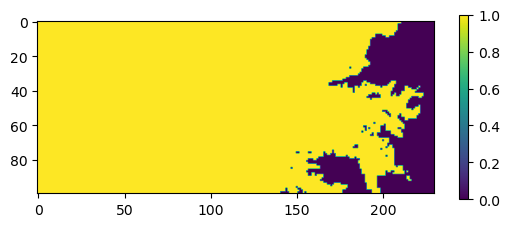

In [31]:
# wherever the constant head/specified head bound is the cells need to be active
ibound[0,dem_data>cutoff_elev] = 0
ibound[0,linerast==1] = 1
plt.imshow(ibound[0,:,:])
plt.colorbar(shrink=0.5)

In [32]:
# copy the ibound array to alter the geology array to set these cells as low permeability formations
# either marine or volcanic based
deep_geology = np.invert(ibound[:,:,:].astype(bool))

# reset ibound to all active cells to reduce non-linearity
# still need to take account of no flow cells for lake package
ibound = np.ones([nlay, nrow,ncol])

In [33]:
np.savetxt(gwfm_dir+'/BAS6/deep_geology_'+str(nlay)+'layer.tsv', np.reshape(deep_geology, (nlay*nrow,ncol)), delimiter ='\t')
np.savetxt(model_ws+'/input_data/deep_geology.tsv', np.reshape(deep_geology, (nlay*nrow,ncol)), delimiter ='\t')
# deep_geology = np.loadtxt(m.model_ws+'/input_data/deep_geology.tsv', delimiter ='\t')
# deep_geology = np.reshape(deep_geology, (nlay,nrow,ncol))

### Remove no flow cells in the first layer where there are stream cells

In [34]:
# where the specified head boundary is the cells must be active
# ibound[0,chd_locs[0], chd_locs[1]] = -1

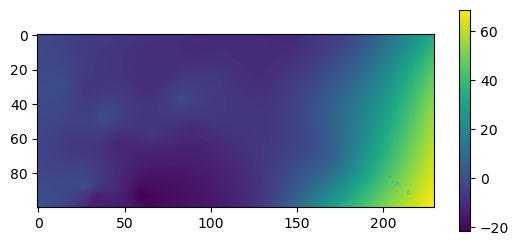

In [35]:
# update steady state to be a best available head contours map
ghb_dir = gwfm_dir+'/GHB_data'

year = strt_date.year # 2016
filename = glob.glob(ghb_dir+'/final_WSEL_arrays/spring'+str(year)+'_kriged_WSEL.tsv')[0]
# convert from ft to meters
hd_strt = np.loadtxt(filename)*0.3048
# where head is  above land surface set to 15 ft below land surface
hd_strt[hd_strt > m.dis.top.array] = m.dis.top.array[hd_strt > m.dis.top.array] - 15*0.3048

dtw_strt = m.dis.top.array - hd_strt
plt.imshow(hd_strt)
plt.colorbar(shrink=0.6)

In [36]:
strt = np.ones((nlay, nrow, ncol), dtype = np.float32)
# The model should start in hydraulic connection
if ss_bool == True:
    strt[:,:,:] = m.dis.top[:,:] #maybe the mean of starting heads i causing issues?

#start with adjusted head contours because the steady state is causing the model to start off
if ss_bool == False:
    strt[:,:,:] = hd_strt

In [37]:
# Basic package, BAS

# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
# add option: STOPERROR 0.01 to reduce percent error when OWHM stops model
# if solver criteria are not met, the model will continue if model percent error is less than stoperror
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt) #, stoper = 1)

In [38]:
# may have to manually add since it seems to overwrite
# allows model to continue even if convergence fails
# bas.options = bas.options +' NO_FAILED_CONVERGENCE_STOP'
# # saves a simple volumetric budget outside of list file
# bas.options = bas.options + 'BUDGETDB flow_budget.txt'


In [39]:
bas.check()
# bas.write_file()


BAS6 PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    isolated cells in ibound array
    Not a number



## Northwest and Southeast GHB boundaries based on historical WSEL
**Units are in feet** 

In [40]:
def get_layer_from_elev(elev, botm_slice, nlay):
    """  Return uppermost model layer (0-based) occupied at least partly by some elevation data
    Parameters
    ----------
    elev: 1D array (n) with elevations matching model elevation units
    botm: 2D array (nlay, n) with layer elevations of model using same x,y locations at elev1D
    """
    elev_lay = np.zeros(len(elev))
    for k in np.arange(0,nlay-1):
        for j in np.arange(0,len(elev)):
            if botm_slice[k,j] > elev[j]:
                elev_lay[j] = k + 1
    return(elev_lay.astype(int))
                


In [41]:
# raster cropping will be done in outside script so the only part read in will be the final array
ghb_dir = gwfm_dir+'/GHB_data'

In [42]:
strtyear = strt_date.year
endyear = end_date.year+1
kriged_fall = np.zeros((int(endyear-strtyear),nrow,ncol))
kriged_spring = np.zeros((int(endyear-strtyear),nrow,ncol))

# keep track of which place in array matches to year
year_to_int = np.zeros((endyear-strtyear,2))

for t, year in enumerate(np.arange(strtyear,endyear)):
    # load and place spring kriged data in np array, load spring first
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/spring'+str(year)+'_kriged_WSEL.tsv')[0]
    # convert from feet to meters
    kriged_spring[t,:,:] = np.loadtxt(filename)*0.3048
    # load and place fall kriged data in np array
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/fall'+str(year)+'_kriged_WSEL.tsv')[0]
    # convert from feet to meters
    kriged_fall[t,:,:] = np.loadtxt(filename)*0.3048

    year_to_int[t,0] = t
    year_to_int[t,1] = year
    

In [43]:
# ceate multi, index to stack fall and spring data
sy_ind = np.repeat(['Apr','Oct'],(endyear-strtyear)),np.tile(np.arange(strtyear,endyear),2)
sy_ind = pd.MultiIndex.from_arrays(sy_ind, names=['month','year'])


In [44]:
# stack fall and spring before resampling
kriged_arr = np.vstack((kriged_spring, kriged_fall))

# Set kriged water table elevations that are above land surface to land surface minus 15 ft (based on historical levels)
# in floodplain elevations can come up to ground surface
# dem_offset = 15*0.3048
dem_offset = 0
kriged_arr = np.where(kriged_arr>dem_data, dem_data- dem_offset, kriged_arr)

kriged = kriged_arr[:, bnd_rows, bnd_cols]


C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


<Axes: >

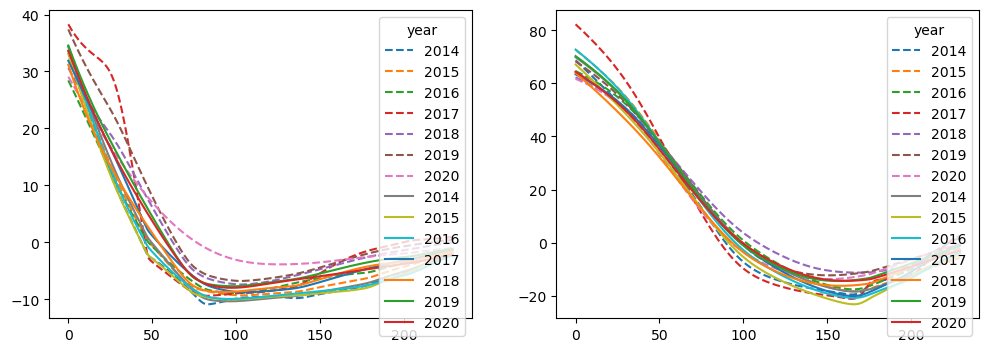

In [45]:
## NW is row 0, SE is last row
kriged_NW = np.vstack((kriged_spring[:,0,:],kriged_fall[:,0,:]))
kriged_SE = np.vstack((kriged_spring[:,nrow-1,:],kriged_fall[:,nrow-1,:] ))
fig,ax=plt.subplots(1,2, figsize=(12,4))
pd.DataFrame(np.rot90(kriged_NW),columns=sy_ind).loc[:,'Apr'].plot(ax=ax[0],linestyle='--')
pd.DataFrame(np.rot90(kriged_NW),columns=sy_ind).loc[:,'Oct'].plot(ax=ax[0])

pd.DataFrame(np.rot90(kriged_SE),columns=sy_ind).loc[:,'Apr'].plot(ax=ax[1],linestyle='--')
pd.DataFrame(np.rot90(kriged_SE),columns=sy_ind).loc[:,'Oct'].plot(ax=ax[1])

## Read in TPROGS data

In [46]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')

gel_dir = gwfm_dir+'/UPW_data'
if 'ZonePropertiesInitial.csv' in os.listdir(model_ws):
    print('exists')
    params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv',index_col='Zone')
else:
    params = pd.read_csv(gel_dir+'/ZonePropertiesInitial.csv',index_col='Zone')
    params.to_csv(model_ws+'/ZonePropertiesInitial.csv')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400    

exists


In [47]:
tprogs_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities'
if tprogs_fxn_dir not in sys.path:
    sys.path.append(tprogs_fxn_dir)
# sys.path
import tprogs_cleaning as tc

from importlib import reload
# importlib.reload
reload(tc)

<module 'tprogs_cleaning' from 'C:\\Users\\ajcalder\\Documents/GitHub/CosumnesRiverRecharge/tprogs_utilities\\tprogs_cleaning.py'>

In [48]:
#  one based is  min:1, 90:mean, max:34
t=89 #0, 33,89
tprogs_info = [80, -80, 320]

tprogs_line = np.loadtxt(tprogs_files[t])
masked_tprogs= tc.tprogs_cut_elev(tprogs_line, dem_data, tprogs_info)
K, Sy, Ss, por = tc.int_to_param(masked_tprogs, params, porosity=True)

# save tprogs facies array as input data for use during calibration
tprogs_dim = masked_tprogs.shape
np.savetxt(model_ws+'/input_data/tprogs_facies_array.tsv', np.reshape(masked_tprogs, (tprogs_dim[0]*nrow,ncol)), delimiter='\t')
# masked_tprogs = np.reshape(np.loadtxt(model_ws+'/input_data/tprogs_facies_array.tsv', delimiter='\t'), (320,100,230))


In [49]:
# the first layer starts at -10 m which corresponds to 20 layers below 0
# 0m AMSL is 160 layers above the bottom of tprogs which ends up giving 160-20 is layer 140 or 139 for 0 based

## LPF/UPW package

In [50]:
hk = np.zeros(botm.shape)
vka = np.zeros(botm.shape)
sy = np.zeros(botm.shape)
ss = np.zeros(botm.shape)

In [51]:
from scipy.stats import hmean, gmean
Kx_upscaled = np.zeros((num_tprogs,nrow,ncol))
Kz_upscaled = np.zeros((num_tprogs,nrow,ncol))
Sy_upscaled = np.zeros((num_tprogs,nrow,ncol))
Ss_upscaled = np.zeros((num_tprogs,nrow,ncol))

for k in np.arange(1,num_tprogs+1):
    # calculate upscale from bottom up
    Kx_upscaled[-k,:,:] = np.nanmean(K[(-k*upscale):(-k*upscale-upscale):-1,:,:],axis=0)
    Kz_upscaled[-k,:,:] = hmean(K[(-k*upscale):(-k*upscale-upscale):-1,:,:],axis=0)
    Sy_upscaled[-k,:,:] = np.nanmean(Sy[(-k*upscale):(-k*upscale-upscale):-1,:,:],axis=0)
    Ss_upscaled[-k,:,:] = np.nanmean(Ss[(-k*upscale):(-k*upscale-upscale):-1,:,:],axis=0)

In [52]:
# # take of 2 for the bottom layers and 1 for the unsat zone layer up top
hk[1:-2,:,:] = Kx_upscaled
vka[1:-2,:,:] = Kz_upscaled
sy[1:-2,:,:] = Sy_upscaled
ss[1:-2,:,:] = Ss_upscaled

The LPF package should use the means for the complete TPROGs layers available for the first layer

In [53]:
top = m.dis.top.array
bot1 = m.dis.botm.array[0,:,:]
# set parameters based on upscaled unsaturated zone
hk[0,:,:] = np.mean(tc.get_tprogs_for_elev(K, top, bot1,tprogs_info),axis=0)
vka[0,:,:] = hmean(tc.get_tprogs_for_elev(K, top, bot1,tprogs_info),axis=0)
sy[0,:,:] = np.mean(tc.get_tprogs_for_elev(Sy, top, bot1,tprogs_info),axis=0)
ss[0,:,:] = np.mean(tc.get_tprogs_for_elev(Ss, top, bot1,tprogs_info),axis=0)



In [54]:
rows,cols = grid_p.row.values-1, grid_p.column.values-1

Trying a VANI of 10 for the tprogs units to allow some vertical gradient forcing

In [55]:
# check proportions of hydrofacies in TPROGs realization
tprogs_vals = np.arange(1,5)
tprogs_hist = np.histogram(masked_tprogs, np.append([0],tprogs_vals+0.1))[0]
tprogs_hist = tprogs_hist/np.sum(tprogs_hist)

tprogs_quants = 1 - np.append([0], np.cumsum(tprogs_hist)/np.sum(tprogs_hist))
vka_quants = pd.DataFrame(tprogs_quants[1:], columns=['quant'], index=tprogs_vals)
# dataframe summarizing dominant facies based on quantiles
vka_quants['vka_min'] = np.quantile(vka, tprogs_quants[1:])
vka_quants['vka_max'] = np.quantile(vka, tprogs_quants[:-1])
vka_quants['facies'] = params.loc[tprogs_vals].Lithology.values
# scale vertical conductivity with a vertical anisotropy factor based
# on quantiles in the upscaled tprogs data
for p in tprogs_vals:
    vka[(vka<vka_quants.loc[p,'vka_max'])&(vka>vka_quants.loc[p,'vka_min'])] /= params.vani[p]


In [56]:
# this may not be needed
# reduce sand/gravel vka for seepage in LAK/SFR assuming some fining
seep_vka = np.copy(vka)
coarse_cutoff = vka_quants.loc[2,'vka_min'] # sand minimum
seep_vka[seep_vka > coarse_cutoff] /= 10
print('coarse cutoff %.1f' %coarse_cutoff)

coarse cutoff 2.1


The tuff breccia is very dense, hard and low water yielding. It is supposedly responsible for the many "haystack" hills in the eastern part of the county

DWR report has a few final well pumping rates, drawdowns and specific capacities but limited.

Fleckenstein et al. 2006 found the Mehrten had  
Kh = 1 to 1.8 x10^-5 m/s  
Kv = 1 to 1.8 x10^-7 m/s  
vani ~= 100  
Sy = 0.15 to 0.2  
Ss = 1e-4 to 1e-3 m^-1  

In [57]:
# plt.imshow(vka[0,:,:])
# plt.show()
# plt.imshow(hk[0,:,:])
# plt.show()
# plt.imshow(deep_geology[0,:,:])
# plt.show()


In [58]:
# set values for second to bottom layer, Laguna formation
hk[-2,:,:] = params.loc[5,'K_m_d']
vka[-2,:,:] = params.loc[5,'K_m_d']/params.loc[5,'vani'] 
sy[-2,:,:] = params.loc[5,'Sy']
ss[-2,:,:] = params.loc[5,'Ss']

# this is causing potentially high water levels in the foothills
# the deep_geology array shows where the mehrten formation comes out of the surface
hk[deep_geology[:,:,:].astype(bool)] = params.loc[6,'K_m_d']
vka[deep_geology[:,:,:].astype(bool)] = params.loc[6,'K_m_d']/params.loc[6,'vani'] 
sy[deep_geology[:,:,:].astype(bool)] = params.loc[6,'Sy']
ss[deep_geology[:,:,:].astype(bool)] = params.loc[6,'Ss']

# set values for bottom layer, Mehrten formation
hk[-1,:,:] = params.loc[6,'K_m_d']
vka[-1,:,:] = params.loc[6,'K_m_d']/params.loc[6,'vani'] 
sy[-1,:,:] = params.loc[6,'Sy']
ss[-1,:,:] = params.loc[6,'Ss']

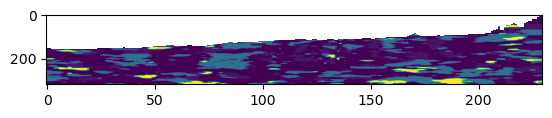

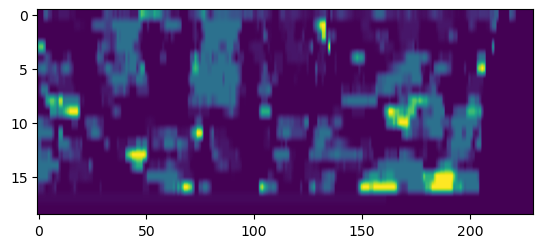

In [59]:
# plt.imshow(K[0,:,:])
# plt.imshow(K[-1,:,:])
row = 50
plt.imshow(K[:,row,:],aspect=1/10)
plt.show()
plt.imshow(hk[:,row,:],aspect=5)
plt.show()

In [60]:
# because I need to maintain a confined sytem for now, I should use the storativity option because
# the gravel has a very low specific storage that might be causing the large jumps
# in groundwater elevation

# may need to adjust to use specific yield only gravel and sand

In [61]:
def calc_storativity(m, ss, sy):
    thickness = np.zeros((m.dis.nlay,m.dis.nrow,m.dis.ncol))
    thickness[0,:,:] = m.dis.top.array - m.dis.botm.array[0,:,:]
    thickness[1:,:,:] =  np.diff(m.dis.botm.array,axis=0)*-1
    # calculate storativity based on layer thickness
    storativity = thickness*ss
    # add specific yield to specific storage 
    storativity += sy
    return(storativity)

storativity = calc_storativity(m, ss, sy)
layer_cutoff = 3
storativity[layer_cutoff:,:,:] -= sy[layer_cutoff:,:,:]

np.savetxt(model_ws+'/input_data/storativity.tsv', np.reshape(storativity,(nlay*nrow, ncol)),
          delimiter=' ', fmt='%.6e')

In [62]:
coarse = (masked_tprogs==1)|(masked_tprogs==2)

In [63]:
# layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
layvka = 0

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# at minimum top layer (water table) should be convertible
# num_unconf = 1
# issue with wells dewatering makes problem if layer is confined
num_unconf = nlay
laytyp = np.append(np.ones(num_unconf), np.zeros(nlay-num_unconf))

# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
laywet = np.zeros(len(laytyp))
laywet[laytyp==1] = 1
#ipakcb = 55 means cell-by-cell budget is saved because it is non zero (default is 53)

gel = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = vka, 
                               sy=sy, ss=ss,
                            laytyp=laytyp, laywet = 0, ipakcb=55) # laywet must be 0 for UPW

# gel = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = vka, 
# #                                ss = storativity, storagecoefficient=True, #storativity
#                                sy=sy, ss=ss, 
#                                laytyp=laytyp, laywet = laywet, ipakcb=55)

In [64]:
gel_nam = pd.Series(['LPF','UPW'])[pd.Series(['LPF','UPW']).isin(m.get_package_list())].values[0]
gel = getattr(m,gel_nam)
frac = [0, 0.582, 0.159, 0.203, 0.056]
frac = np.cumsum(frac)
print('TPROGs fractions/quantiles: ',frac)
for n in ['hk','vka','sy','ss']:
    q = np.quantile(getattr(gel,n).array,frac)
    print(n,  list('{:8.2E}'.format(qn, '.2E') for qn in q))
# # np.histogram?

TPROGs fractions/quantiles:  [0.    0.582 0.741 0.944 1.   ]
hk ['5.62E-01', '8.64E+00', '4.30E+01', '1.30E+02', '3.46E+02']
vka ['8.64E-03', '6.41E-01', '1.44E+00', '1.30E+02', '3.46E+02']
sy ['1.00E-01', '1.20E-01', '1.50E-01', '2.00E-01', '2.50E-01']
ss ['2.00E-05', '3.20E-04', '5.00E-04', '5.00E-04', '5.00E-04']


In [65]:
# gel.write_file()

In [66]:
gel.check()
# option to make switching between packages easier
# 'LPF' in m.get_package_list()


UPW PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative specific yield values
    specific yield values below checker threshold of 0.01
    specific yield values above checker threshold of 0.5



## Review geologic parameters

In [67]:
plt_dir = gwfm_dir+'/Levee_setback/figures/'

In [68]:

# lays2plt = [0,1,2]
# plt_cols = 3
# fig,ax=plt.subplots(int(np.ceil(len(lays2plt)/plt_cols)), plt_cols, figsize=(12,4),sharex='col',sharey='row')
# fig.tight_layout()

# for n,k in enumerate(lays2plt):
#     ax_n = ax[int(n / plt_cols), n % plt_cols]
#     im = ax_n.imshow(hk[k,:,:], norm = mpl.colors.LogNorm(vmin = hk.min(), vmax=hk.max()))
#     ax_n.set_title('Layer '+str(k))
# hcb = plt.colorbar(im, shrink = 0.5,ax=ax)
# hcb.set_label('Horizontal Conductivity (m/d)')
# # plt.savefig(plt_dir+'Horizontal_conductivity_select_layers.png',dpi=600,bbox_inches='tight')

# # plt.colorbar(mappable=im)
# print('HK of Mehrten and Laguna: ',np.unique(hk[19,:,:]))
# print('Layer 1 range: ', np.histogram(hk[0,:,:],4)[1])
# print('Layer 5 range: ',np.histogram(hk[4,:,:],4)[1])

### Scaling factors for GHB, RIV, UZF/RCH and WEL package

In [69]:
gel_dir = gwfm_dir+'/UPW_data'
if 'GHB_UZF_WEL_scaling.csv' in os.listdir(model_ws):
    scaling_factors = pd.read_csv(model_ws+'/GHB_UZF_WEL_scaling.csv',delimiter = ',')
else:
    scaling_factors = pd.read_csv(gel_dir+'/GHB_UZF_WEL_scaling.csv',delimiter = ',')
    scaling_factors.to_csv(model_ws+'/GHB_UZF_WEL_scaling.csv')

scaling_factors_all = scaling_factors.copy()
# convert from K (m/s) to K (m/d)
scaling_factors_all.loc[scaling_factors_all.GroupName.isin(['GHB']),'StartValue']*=86400


scaling_factors = scaling_factors.set_index('ParamName')['StartValue']

## Import soil data for Lake Package, UZF Package, SFR Package hydraulic parameters

In [70]:
mb_name = gwfm_dir+"/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"

mb = gpd.read_file(mb_name)
mb = mb.to_crs('epsg:32610')

### Load grid_uzf to shapefile

In [71]:
uzf_dir = gwfm_dir+'\\UZF_data'
soil_dir = join(uzf_dir, 'final_soil_arrays')

In [72]:
# grid_uzf = gpd.read_file(uzf_dir+'/final_grid_uzf/griduzf.shp')

In [73]:
soilKs_array = np.loadtxt(soil_dir+'/final_soilKs.tsv', delimiter = '\t')
soiln_array = np.loadtxt(soil_dir+'/final_soiln.tsv', delimiter = '\t')
soileps_array = np.loadtxt(soil_dir+'/final_soileps.tsv', delimiter = '\t')
soildepth_array = np.loadtxt(soil_dir+'/final_soildepth.tsv', delimiter = '\t')

# newly created 4/6/2023 to tamp down overestimates of recharge in foothills
runoff_coeff = np.loadtxt(join(soil_dir, 'final_soil_runoff_coeff.csv'),  delimiter=',')


# SFR

In [74]:
sfr_dir = gwfm_dir+'/SFR_data/'

## Adjust Blodgett Dam scenario here

In [75]:
# scenario = 'dam'
# scenario = 'actual'
# scenario = 'new'
scenario = 'none'

In [76]:
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')


In [77]:
XS8pt = pd.read_csv(sfr_dir+'8pointXS.csv')
# XSlocs = gpd.read_file(sfr_dir+'8pointXS_locs/8pointXS_locs.shp')
# new shapefile with an extra point for blodgett dam as site 16.5
XSlocs = gpd.read_file(gwfm_dir+'/Blodgett_Dam/geospatial/8pointXS_locs/8pointXS_locs.shp')
XSlocs.crs = 32610

XSg  = gpd.sjoin(grid_sfr, XSlocs, how = "inner", predicate= "contains", lsuffix = 'sfr',rsuffix = 'xs')
# print(len(XSg))

# # Append the grid_breach location to the list of cross sections to split the segment
# XSg = XSg.append(grid_breach).sort_values('reach')
# # Copy the XS site name from the previous last site to the breach site to keep same XS
# XSg.Site.iloc[-1] = XSg.Site.iloc[-2]
# len(XSg), len(XS8pt.loc[0,:])/2

if scenario == 'none':
    # if no blodgett dam scenario then remove the extra cross section
    XSg = XSg.loc[(XSg.Site!=16.5)]
    XSg = XSg.loc[(XSg.Site!=16.2)]
#     XSg = XSg.loc[XSg.Site!=16.2]
elif scenario == 'actual':
    XSg_side = XSg.loc[XSg.Site==16.5]
    XSg_side.loc[:,'Site'] = 16.4
    XSg = XSg.append(XSg_side)
elif scenario == 'design':
    # may or may not want to remove the segment before
    XSg = XSg.loc[(XSg.Site!=16.2)]

# if the scneario is the restructured or designed dam then no change in the segments is necessary
# sort by site to make sure any XS added are properly included
XSg = XSg.sort_values('Site')
# print(len(XSg))


In [78]:
XSg['iseg'] = np.arange(2,len(XSg)+2) # add the segment that corresponds to each cross section

In [79]:

# if scenario == 'dam':
#     # designed scenario flow through dam only
#     new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/02_designed_XS.csv', skiprows=1)
# elif scenario =='actual':
#     # current situation, flow around dam and after dam
#     new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/03_actual_XS.csv', skiprows=1)
# elif scenario =='new':
#     # depending scenario, use different input cross sections for 16.5
#     new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/01_New_wide_XS.csv')

# if there is a scneario then need to add the new XS
if scenario != 'none':
    XS8pt = pd.concat([XS8pt,new_xs],axis=1)

some of the XS are not lining up with grid_sfr so they aren't being connected. Need to fix this and also look at how many XS are really needed to capture the change in river morphology

### Read in 8 pt XS, revised by simplifying from Constantine 2001

In [80]:
# There is one reach for each cell that a river crosses
NSTRM = -len(grid_sfr)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = 1 + len(XSg) 
# NSS = 2
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 86400 # mannings constant for SI units, 1.0 for seconds, 86400 for days
# real value equal to the tolerance of stream depth used in
# computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55
# writes out stream depth, width, conductance, gradient when cell by cell
# budget is specified and istcb2 is the unit folder
ISTCB2 = 54
# isfropt = 1 is no unsat flow
# specifies whether unsat flow beneath stream or not, isfropt 2 has properties read for each reach, isfropt 3 also has UHC
# read for each reach, isfropt 4 has properties read for each segment (no UHC), 5 reads for each segment with UHC
ISFROPT = 1
# nstrail (int), number of trailing weave increments used to represent a trailing wave, used to represent a decrease 
# in the surface infiltration rate. Can be increased to improve mass balance, values between 10-20 work well with error 
# beneath streams ranging between 0.001 and 0.01 percent, default is 10 (only when isfropt >1)
NSTRAIL = 20
# isuzn (int) tells max number of vertical cells used to define the unsaturated zone beneath a stream reach (default is 1)
ISUZN = 1
#nsfrsets (int) is max number of different sets of trailing waves (used to allocate arrays), a value of 30 is sufficient for problems
# where stream depth varies often, value doesn't effect run time (default is 30)
NSFRSETS = 30
# IRTFLG (int) indicates whether transient streamflow routing is active, must be specified if NSTRM <0. If IRTFLG >0 then
# flow will be routed with the kinematic-wave equations, otherwise it should be 0 (only for MF2005), default is 1
IRTFLG = 1
# numtim (int) is number of sub time steps used to route streamflow. Streamflow time step = MF Time step / NUMTIM. 
# Default is 2, only when IRTFLG >0
NUMTIM = 1
# weight (float) is a weighting factor used to calculate change in channel storage 0.5 - 1 (default of 0.75) 
WEIGHT = 0.75
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
# 0.00003 m3/s = 2.592 m3/day
# a flow tolerance of 1 cfs is equal to 2446.57 m3/day
# if my units are in m3/day then flwtol should be in m3/day
FLWTOL = 0.00003*CONST


sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, nstrail = NSTRAIL, isuzn = ISUZN, irtflg = IRTFLG, 
                          numtim = NUMTIM, weight = WEIGHT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=True,
                                tabfiles_dict={1: {'numval': nper, 'inuit': 56}})

In [81]:
# Add option block at the top of the sfr input file for tabfiles
# tab_option = flopy.utils.OptionBlock(options_line = ' reachinput transroute tabfiles 1 ' + str(nper), package = sfr, block = True)

options_line = ' reachinput transroute tabfiles 1 ' + str(nper) + ' no_reach_layer_change'
tab_option = flopy.utils.OptionBlock(options_line = options_line, package = sfr, block = True)
sfr.options = tab_option


In [82]:
# Modflow NWT additions to SFR package set up
# sfr.transroute = True
# sfr.reachinput = True
# sfr.tabfiles = True
# # numval is the number of values in the flow tab files, inuit is the corresponding unit file
# sfr.tabfiles_dict = {1: {'numval': nper, 'inuit': 56}}

In [83]:
xs_sfr = grid_sfr.set_index('reach')
# set all reaches to start as segment 1 which will be changed iteratively based on the number of cross-sections
xs_sfr['iseg'] = 1
# add a column reach_new that will be changed iteratively as the segment number is changed
xs_sfr['reach_new'] = xs_sfr.index
# xs_sfr

## Define reach data based on ISFROPT

In [84]:
## Given the reach number of each XS, the 718 reaches will be broken down into each segment
## create a new reach column based on XS reach number and 

# segcount = 2
for i in np.arange(0,len(XSg)):
    temp_reach = XSg.reach.values[i]
    rchnum = xs_sfr.index[-1] - temp_reach+1
    xs_sfr.reach_new.loc[temp_reach:] = np.linspace(1,rchnum, rchnum)
#     xs_sfr.iseg.loc[temp_reach:] = segcount
    xs_sfr.iseg.loc[temp_reach:] = XSg.iseg.values[i]
#     segcount +=1
    
# for simple 1 XS model
# temp_reach = XSg.reach
# rchnum = xs_sfr.index[-1] - temp_reach+1
# xs_sfr.reach_new.loc[temp_reach:] = np.linspace(1,rchnum, rchnum)
# xs_sfr.iseg.loc[temp_reach:] = segcount
# segcount +=1

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_60040\2518049789.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xs_sfr.reach_new.loc[temp_reach:] = np.linspace(1,rchnum, rchnum)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_60040\2518049789.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xs_sfr.iseg.loc[temp_reach:] = XSg.iseg.values[i]


In [85]:
xs_sfr.reach_new = xs_sfr.reach_new.astype(int)


In [86]:
sfr_rows = (grid_sfr.row.values-1).astype(int)
sfr_cols = (grid_sfr.column.values-1).astype(int)
# Determine which layer the streamcell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
sfr_top = grid_sfr.z_min.values 
sfr_bot =  sfr_top - soildepth_array[sfr.reach_data.i, sfr.reach_data.j]
sfr_lay = get_layer_from_elev(sfr_bot, botm[:, sfr_rows, sfr_cols], m.dis.nlay)


In [87]:
# plt.plot(botm[sfr_lay, sfr_rows, sfr_cols])
# plt.plot(sfr_bot)
# plt.plot(sfr_top)


In [88]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr.reach_data.node = grid_sfr.index
sfr.reach_data.k = sfr_lay.astype(int)
sfr.reach_data.i = sfr_rows
sfr.reach_data.j = sfr_cols
sfr.reach_data.iseg = xs_sfr.iseg
sfr.reach_data.ireach = xs_sfr.reach_new
sfr.reach_data.rchlen = xs_sfr.length_m.values
sfr.reach_data.strtop = sfr_top
sfr.reach_data.slope = grid_sfr.slope.values
 # a guess of 2 meters thick streambed was appropriate
sfr.reach_data.strthick = soildepth_array[sfr.reach_data.i, sfr.reach_data.j]

# UZF parameters
sfr.reach_data.thts = soiln_array[sfr.reach_data.i, sfr.reach_data.j]/100
sfr.reach_data.thti = sfr.reach_data.thts
sfr.reach_data.eps = soileps_array[sfr.reach_data.i, sfr.reach_data.j]
sfr.reach_data.uhc = seep_vka[0,sfr.reach_data.i, sfr.reach_data.j]


In [89]:
grid_sfr['dist_m'] = grid_sfr.length_m.cumsum()
grid_sfr.dist_m -= grid_sfr.dist_m.iloc[0]

## Could try TPROGs alternative 

In [90]:
topbotm = np.zeros((m.dis.nlay+1,m.dis.nrow,m.dis.ncol))
topbotm[0,:,:] = m.dis.top.array
topbotm[1:,:,:] = m.dis.botm.array

Text(0.5, 0, 'Reach')

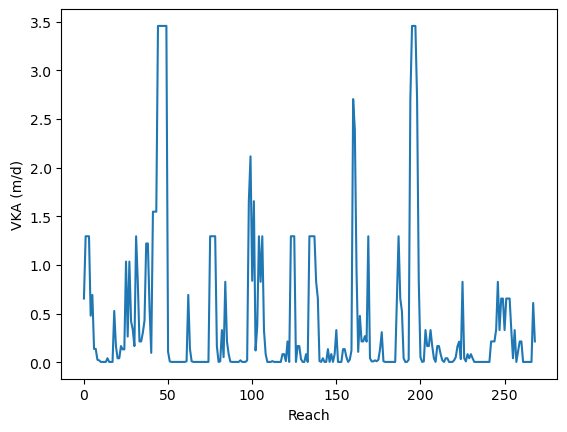

In [91]:
strbd_thick = 4
top = m.dis.top.array.copy()
# use values of stream top instead of DEM top
top[sfr_rows, sfr_cols] = grid_sfr.z.values
bot_str_arr = top - strbd_thick
# get_tprogs_for_elev(K, m_c.dis.top.array, m_c.dis.top.array- np.linspace(1,4,m_c.dis.ncol), rows = sfr_rows, cols = sfr_cols)
strbd_tprogs = tc.get_tprogs_for_elev(K, top, bot_str_arr, tprogs_info,rows = sfr_rows, cols = sfr_cols)
sfr_K = gmean(strbd_tprogs,axis=0)/100 # divide by 100 to ease convergence, but variability is still there
plt.plot(sfr_K)
plt.ylabel('VKA (m/d)')
plt.xlabel('Reach')
# temp fix to get convergence
# sfr_K = 0.01

In [92]:
# set stream hydraulic conductivity based on soil maps
# sfr.reach_data.strhc1 = soilKs_array[sfr.reach_data.i, sfr.reach_data.j]*scalingfactors.RIV
# set hydraulic conductivity smaller than aquifer hydraulic conductivity to limit interaction
# and ease the numerical stress
sfr.reach_data.strhc1 = sfr_K
# or use VKA scaled back for gravel/sand
sfr.reach_data.strhc1 = seep_vka[0,sfr.reach_data.i, sfr.reach_data.j]

# calibration of the whole river now by scaling conductivity
m.sfr.reach_data.strhc1 = m.sfr.reach_data.strhc1
# next step is to break river up into reaches based on the grain size analysis or perhaps just by stream segment

The range of of maximum log(river bed K) (m/s) from Fleckenstein's cosumnes paper was -4.0 to -4.8 which gives VKA = 1.6e-5 to 1E-4 m/s and 1.38 - 8.64 m/day. Minimim of 1E-7 m/s or 8.64E-3 m/day. The mean was around 0.17 m/day

In [93]:
# sfr.write_file()

With no sfr K reduction, the model failed to converge in stress period 12 time step 3. With sfr K reduced by a factor of 1/100 the model ran to stress period 1246 time step 4 while the previous model with low K went to stress period 2026 time step 4. Dividing by 1000 actually caused the model to fail to converge at stress period 100 which shows that there was not enough water coming in to the aquifer from the stream, and 

In [94]:
mb4rl = pd.read_csv(sfr_dir+'michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')
# mb4rl.plot(x='gage_height_va',y='discharge_va', legend = False)
# plt.xlabel('Gage height (m)')
# plt.ylabel('Discharge $(m^3/d$)')
# plt.ticklabel_format(style='scientific') # plain to show all zeros
# plt.title('Simplified USGS Michigan Bar Rating Curve')
# plt.savefig('Plots/Model_SFR_UZF_Progress/MB_ratingcurve', dpi = 300, bbox_inches='tight')

## Define segment data

Median grain size (mm) ranges from 1 mm – 30 mm along surveyed sites, which gives a range of 0.026-0.035 for a stable channel
Moderate channel irregularity due to channel scouring and pools alternating, range of 0.006-0.010
Gradual cross section change: 0.000 adjustment
Effect of obstructions: minor due to occasional downed logs and debris in river, 0.005-0.015
Amount of vegetation: large on banks due to willows and cottonwood trees, 0.025-0.050, and negligible in the channel
Degree of meandering: minor due to levees, m = 1.0

n = (nb+n1+n2+n3+n4)*m (b=base,1=surface irregularity, 2 = XS variation, 3 = obstructions, 4 = vegetation, m = correction for meandering)
n = (0.03+0.08+0.01) = 0.048 in channel
n = (0.048 +0.03) = 0.078 on banks


In [95]:
sfr_seg = sfr.segment_data[0].copy()

In [96]:
# There is one dictionary key for each stress period (starting at 0) and in each dictionary key there is a 
# rec array holding an entry for each stream segment where nseg shows which segment it is (ie no dictionary key for segment)
# If ITMP = 0 Item 4 is used, if ITMP >0 Item 6 is used, 
# if ITMP <0 the stream segment data not defined in Item 4 will be reused form the last stress period

# Define stress period data need one for each stress period
# Dataset 5 will be built automatically from segment_data unless specified
# ITMP (int) for reusing or reading stream seg data that can change each stress period
#IRDFLG, 0 is input data printed, greater than 0 input data is not printed
# doesn't seem to change the value
# IPTFLG, 0 is streamflow-routing results printed, greater than 0 not

In [97]:
# 15.0=14, 16.2 = 15, 16.4 = 16, 16.5 = 17, 17.0=18
# 14 outseg will be the side channel (16), 15 is the diversion before the Dam from 14 iupseg
# outseg for 15 will be -1 for the lake representing BLodgett Dam
# there is a diversion from 15 (segment to Dam) to 16 (side channel) to correct for the flood diversion
# so that below 500 cfs flow only goes to the side channel and above 500 cfs flow is 80% to Dam and 20% to side channel
# based on the idea that the side channel has a XS roughly 1/4 the size of the main channel and under high flows there
# will be more depth and force that flow will most likely be dominantly straight and avoid the side channel more

# if scenario =='actual':
#     pre_seg = XSg.loc[XSg.Site==16.2,'iseg'].iloc[0]
#     side_seg = XSg.loc[XSg.Site==16.4,'iseg'].iloc[0]
# elif (scenario =='actual') | (scenario=='design'):
#     post_seg = XSg.loc[XSg.Site==16.5,'iseg'].iloc[0]
# print(pre_seg,side_seg,post_seg)

In [98]:
# alternate version of segment data loading using if statements when filtering data rather than in a loop
sfr_seg.nseg = np.arange(1,NSS+1)

sfr_seg.icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
sfr_seg.icalc[0] = 4 # use stage, discharge width method for Michigan Bar (nseg=1)
sfr_seg.nstrpts[sfr_seg.icalc==4] = len(mb4rl) # specify number of points used for flow calcs
sfr_seg.outseg = sfr_seg.nseg+1 # the outsegment will typically be the next segment in the sequence
sfr_seg.iupseg = 0 # iupseg is zero for no diversion
# correct outseg and iupseg to account for Blodgett Dam scenario
# if scenario =='design':
#     sfr_seg.outseg[sfr_seg.nseg==post_seg-1]=-1 # segment before dam flows to lake
#     sfr_seg.iupseg[sfr_seg.nseg==post_seg]=-1 # lake outflow is diverted to segment after dam
# elif scenario == 'actual':
#     sfr_seg.outseg[sfr_seg.nseg==pre_seg-1] = side_seg # the river should flow to the side segment first
#      # there will be a diversion from the river to the dam above 500 cfs, of which 20% will be returned to the side channel
#     sfr_seg.iupseg[sfr_seg.nseg==pre_seg] = pre_seg-1
#     sfr_seg.iprior[sfr_seg.nseg==pre_seg] = -3 # iprior=-3 any flows above the flow specified will be diverted
#     sfr_seg.flow[sfr_seg.nseg==pre_seg] = 500*0.3048*86400 # 500 cfs is the start of higher flow in the Cosumnes
#     sfr_seg.outseg[sfr_seg.nseg==pre_seg] = -1 #outflow from short segment before Dam is the LAK for the dam

#     # adjust for flow from pre dam segment back to side channel
#     sfr_seg.iupseg[sfr_seg.nseg==side_seg] = pre_seg
#     sfr_seg.iprior[sfr_seg.nseg==side_seg] = -2 # the flow diverted is a % of the total flow in the channel
#     sfr_seg.flow[sfr_seg.nseg==side_seg] = 0.2 # the side channel is about 1/4 the size so 20% of flow should run through
#     # divert flow from lake back into the segment after the dam
#     sfr_seg.iupseg[sfr_seg.nseg==post_seg] = -1 # no need to change iprior because diversion is based on lake stage
    
# set a flow into segment 1 for the steady state model run
sfr_seg.flow[0] = 2.834*86400. # m3/day, originally 15 m3/s
# set the values for ET, runoff and PPT to 0 as the inflow will be small relative to the flow in the river
sfr_seg.runoff = 0.0
sfr_seg.etsw = 0.0
sfr_seg.pptsw = 0.0

# Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
# RoughCH is only specified for icalc = 1 or 2
sfr_seg.roughch[(sfr_seg.icalc==1) | (sfr_seg.icalc==2)] = 0.048
# ROUGHBK is only specified for icalc = 2
sfr_seg.roughbk[(sfr_seg.icalc==2) | (sfr_seg.icalc==5)] = 0.083# higher due to vegetation

In [99]:
sfr.segment_data[0] = sfr_seg

In [100]:
# Pull out data for upstream and downstream reach of each segment
up_data = xs_sfr.drop_duplicates('iseg')
dn_data = xs_sfr.sort_values('reach_new',ascending = False).drop_duplicates('iseg').sort_values('iseg')


# Need to return to later and remove hard coding
# These are getting used for initial guesses
# Read in first stress period when ICALC = 1 or 2 and ISFROPT is 5
# Dataset 6b
sfr.segment_data[0].hcond1 = sfr.reach_data.strhc1[0]
sfr.segment_data[0].thickm1 = 2
sfr.segment_data[0].elevup = up_data.z.values
sfr.segment_data[0].width1 = 20
sfr.segment_data[0].depth1 = 1
sfr.segment_data[0].thts1 = 0.4
sfr.segment_data[0].thti1 = 0.15
sfr.segment_data[0].eps1 = 4
sfr.segment_data[0].uhc1 = sfr.reach_data.strhc1[0]

# Dataset 6c
sfr.segment_data[0].hcond2 = sfr.reach_data.strhc1[-1]
sfr.segment_data[0].thickm2 = 2
sfr.segment_data[0].elevdn = dn_data.z.values
sfr.segment_data[0].width2 = 20
sfr.segment_data[0].depth2 = 1
sfr.segment_data[0].thts2 = 0.4
sfr.segment_data[0].thti2 = 0.15
sfr.segment_data[0].eps2 = 4
sfr.segment_data[0].uhc2 = sfr.reach_data.strhc1[-1]


In [101]:
# Change column name to float type for easier referencing in iteration
XS8pt.columns = XS8pt.columns.astype('float')
# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(2,len(XSg)+2)}  }

xsnum = 2
for k in XSg.Site.values:
        pos = int(XS8pt.columns.get_loc(k))
        XCPT = XS8pt.iloc[:,pos].values
        ZCPT = XS8pt.iloc[:,pos+1].values
        ZCPT_min = np.min(ZCPT)
        ZCPT-= ZCPT_min
        sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
        xsnum += 1



In [102]:
FLOWTAB = mb4rl.discharge_va.values
DPTHTAB = mb4rl.gage_height_va.values
WDTHTAB = mb4rl.chan_width.values
sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

In [103]:
# sfr.plot_path(start_seg=1, end_seg=0, plot_segment_lines=True)
# plt.savefig('Plots/Model_SFR_UZF_Progress/sfr_elev_vs_model_top.png', dpi = 600, bbox_inches='tight')

### Tab Files for SFR

2010-2014 inflow mean is 2/3 2014-2018. 2014-2018 median was 1/7 the mean of 2014-2018

In [104]:
# For the tab files the left column is time (in model units) and the right column is flow (model units)
# Time is days, flow is cubic meters per day
# USGS presents flow in cfs (cubic feet per second)
inflow = pd.read_csv(sfr_dir+'MB_daily_flow_cfs_2010_2019.csv', index_col = 'datetime', parse_dates = True)
# covnert flow from cubic feet per second to cubic meters per day
inflow['flow_cmd'] = inflow.flow_cfs * (86400/(3.28**3))

# filter out data between the stress period dates
inflow_ss = inflow.loc[ss_strt:strt_date]
inflow = inflow.loc[strt_date:end_date]

# time_flow = np.vstack((np.arange(time_tr0,len(inflow.flow_cmd)+time_tr0),inflow.flow_cmd))
# time_flow = np.transpose(time_flow)
# correct model time for start of transient periods, uses perlen not just assuming days

flw_time = perlen[:-1]
if ss_bool == False:
    flw_time = perlen[:]
time_flow = np.transpose((np.cumsum(flw_time), inflow.flow_cmd))

# add a first row to account for the steady state stress period
# median instead of mean because of too much influence from large values
if ss_bool == True:
#     time_flow = np.row_stack(([0, inflow.flow_cmd.median()], time_flow))
    time_flow = np.row_stack(([0, inflow_ss.flow_cmd.mean()], time_flow))

np.savetxt(model_ws+'/MF.tab',time_flow, delimiter = '\t')

In [105]:
# inflow.flow_cfs.hist(bins = [0,150,1500, 3000,10000,20000])
# fig,ax=plt.subplots(figsize=(8,4))
# inflow.plot(y='flow_cfs',legend=False,ax=ax)
# plt.ylabel('Streamflow (cfs)',size=16)
# plt.xlabel('Date',size=16)
# plt.savefig(plt_dir+'streamflow_michigan_bar.png',dpi=600,bbox_inches='tight')

In [106]:
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'tab',unitnumber = 56)

Outside Package class

"When subsurface recharge (MBR2) is negligible,
stream runoff at the mountain front (runoff measured at
point B in Figure 1, or RO) may be considered the total
contribution to MFR [Anderholm, 2000]." (Wilson and Guan 2004)

## GHB NW, SE set up

In [107]:

# # should bring back monthly interpolate along defined boundaries
# rot90 caused an issue with flipping row and column direction
kriged_df = pd.DataFrame(np.transpose(kriged),columns=sy_ind)
# long format for easier resampling and create datetime column
df_long = kriged_df.melt(ignore_index=False).reset_index(names='grid_id') # keep index it row or col number
df_long['date'] = pd.to_datetime(df_long.year.astype(str)+'-'+df_long.month)
# linearly interpolate between fall and spring measurements for each row,col id
df_mon = df_long.set_index('date').groupby(['grid_id']).resample('MS').interpolate('linear')
df_mon = df_mon.reset_index('grid_id', drop=True)
df_mon['year'] = df_mon.index.year
df_mon['month'] = df_mon.index.month

df_mon = df_mon.join(bnd_cells.set_index('grid_id'),on='grid_id')

# for one year this calculation doesn't take long
df_mon['layer'] = get_layer_from_elev(df_mon.value.values, botm[:, df_mon.row, df_mon.column], m.dis.nlay)
# correct kriged elevations so if head is below cell bottom it is set to the mid elevation of the cell
df_mon['botm'] = botm[df_mon.layer, df_mon.row, df_mon.column] 
df_mon['botm_adj'] = (df_mon.botm + botm[df_mon.layer-1, df_mon.row, df_mon.column])/2
df_mon.loc[df_mon.value < df_mon.botm, 'value'] = df_mon.loc[df_mon.value < df_mon.botm, 'botm_adj']

# can calculate nw, se and upstream boundary uniformly
# just drop row,col on delta boundary
df_mon = df_mon[df_mon.column!=0]
# drop row,col in foothills
df_mon = df_mon[df_mon.column!=ncol-1]

# drop ghb in inactive cells?
df_mon = df_mon[ibound[df_mon.layer, df_mon.row,df_mon.column].astype(bool)]

# average value for boundary testing
# ghb_ss = df_mon.groupby(['layer','row','column']).mean()
# use heads that should appear at start for steady state
ghb_ss = df_mon.loc[strt_date].groupby(['layer','row','column']).mean().reset_index()
# ghb_ss.value < ghb


In [108]:

def ghb_df(rows, cols, ghb_hd, distance):
    """ Given rows and columns create GHB based on interpolated head levels"""
    # pull out head for rows and columns
    head = ghb_hd.loc[list(zip(rows, cols))].value.values
    ghb_lay = get_layer_from_elev(head, botm[:,rows, cols], m.dis.nlay)

    df = pd.DataFrame(np.zeros((np.sum(nlay - ghb_lay),5)))
    df.columns = ['k','i','j','bhead','cond']
    # get all of the i, j,k indices to reduce math done in the for loop
    n=0
    nk = -1
    for i, j in list(zip(rows,cols)):
        nk +=1
        for k in np.arange(ghb_lay[nk], nlay):
            df.loc[n,'i'] = i
            df.loc[n,'j'] = j
            df.loc[n,'k'] = k
            n+=1
    df[['k','i','j']] = df[['k','i','j']].astype(int)
    cond = hk[df.k, df.i, df.j]*(top_botm[df.k, df.i, df.j]-top_botm[df.k +1 , df.i, df.j])*delr/distance
    df.cond = cond
    df.bhead = ghb_hd.loc[list(zip(df.i, df.j))].value.values
    # drop cells where the head is below the deepest cell?
    return(df)

In [109]:
months = pd.date_range(strt_date,end_date, freq="MS")
month_intervals = (months-strt_date).days + time_tr0 # stress period
# month_intervals

In [110]:
# only need to recalculate conductance in ucode
def recalc_cond(i,j,k,hk):
    distance = 5000
    delr = m.dis.delr.array.mean()
    cond = hk*(top_botm[k,i,j]-top_botm[k+1,i,j])*delr/distance
    return(cond)


## Southwest GHB boundary (specified head for outflow to the Delta)

How much would the expected head gradient be near the delta, how fast would head decrease with depth.
Perhaps it would only go down a few meters for every layer

In [111]:
distance = 5000
# Fine sand	2×10-7 to 2×10-4 m/s
# Silt, loess	1×10-9 to 2×10-5 m/s
# delta soils have some sand mixed in
delta_hk = (2E-4) *86400
# delta_hk = scaling_factors.K_delta

ghbdelta_spd = pd.DataFrame(np.zeros(((nlay*nrow),5)))
ghbdelta_spd.columns = ['k','i','j','bhead','cond']

# get all of the j,k indices to reduce math done in the for loop
xz = np.zeros((nlay*nrow,2)).astype(int)
n=0
for i in np.arange(0,nrow):
    for k in np.arange(0, nlay):
        xz[n,0] = i
        xz[n,1] = k
        n+=1
cond = delta_hk*(top_botm[xz[:,1],:,0]-top_botm[xz[:,1]+1,:,0])*delr/distance
ghbdelta_spd.cond = cond
ghbdelta_spd.bhead = 0
ghbdelta_spd.k = xz[:,1]
ghbdelta_spd.j = 0
ghbdelta_spd.i = xz[:,0]

# drop ghb in inactive cells?
ghbdelta_spd = ghbdelta_spd[ibound[ghbdelta_spd.k, ghbdelta_spd.i,ghbdelta_spd.j].astype(bool)]

In [112]:
# write to csv for use in UCODE file edits
df_mon.to_csv(m.model_ws+'/input_data/ghb_general.csv', index=True)
ghbdelta_spd.to_csv(m.model_ws+'/input_data/ghbdelta_spd.csv',index=False)

In [113]:
ghb_dict = {}

if ss_bool == True:
    # set steady state period
    ghb_all_ss = ghb_df(ghb_ss.row, ghb_ss.column, ghb_ss.set_index(['row','column']), distance = 500)
    ghb_dict[0] = pd.concat((ghb_all_ss, ghbdelta_spd)).values


for n in np.arange(0, len(months)):
    df_spd = df_mon.loc[months[n]]
    spd = month_intervals[n]
    ghb_gen = ghb_df(df_spd.row, df_spd.column, df_spd.set_index(['row','column']), distance = 500)
    ghb_dict[spd] = pd.concat((ghb_gen, ghbdelta_spd)).values
    


In [114]:

# GHB for east and west model boundaries
ghb = flopy.modflow.ModflowGhb(model=m, stress_period_data =  ghb_dict, ipakcb=55)
# GHB for only Delta, west side of model
# ghb.stress_period_data =  {0: ghbdn_spd}

In [115]:
ghb.check()


GHB PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells
    BC elevation below cell bottom



In [116]:
# ghb.write_file()

## CHD Package Time variant head

In [117]:
chd = flopy.modflow.ModflowChd(model=m,ipakcb=55)

In [118]:
# historical observation data suggested groundwater levels near the foothills are on the range of 40 meters
# and have a steep gradient

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_60040\3024857090.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hill_obs = all_obs[all_obs.column>200].groupby('site_code').mean()


<Axes: >

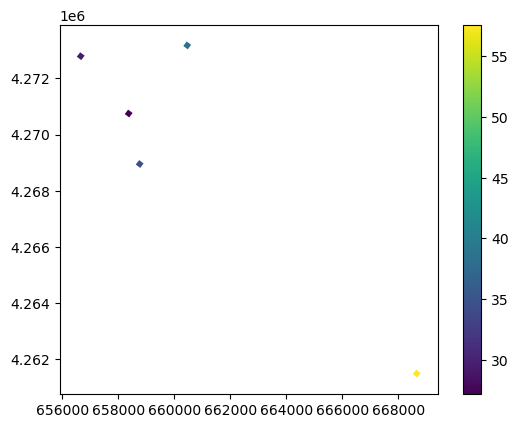

In [119]:
hob_dir = gwfm_dir+'/HOB_data'
# save cleaned data to box data for all data
all_obs = pd.read_csv(hob_dir+'/all_obs_grid_prepared.csv',index_col=0,parse_dates=True)
hill_obs = all_obs[all_obs.column>200].groupby('site_code').mean()
hill_obs
hill_grid = grid_p[grid_p.column>200][['row','column','geometry']]
hill_grid[['row','column']]-=1
hill_grid = hill_grid.join(hill_obs.set_index(['row','column']),on=['row','column'],how='inner')
hill_grid.plot('gwe',legend=True)

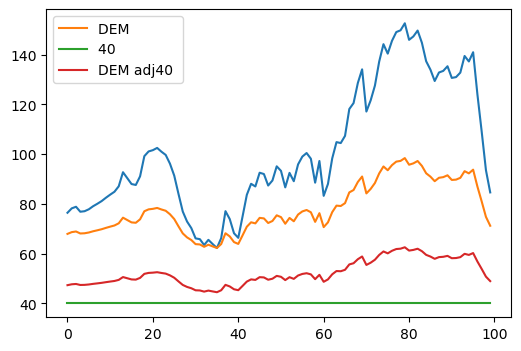

In [120]:
# Determine which layer the specified head cell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)

fig,ax=plt.subplots( figsize=(6,4))
ax.plot(dem_data[:,ncol-1])

chd_lay = np.zeros(nrow)

head = dem_data[:,ncol-1]
headmin = np.min(head)
ch_weight = 0.6
chd_vals = head*(1-ch_weight)+headmin*ch_weight
ax.plot(chd_vals,label='DEM ')

ch_weight = 0.8
chd_vals = np.full(dem_data[:,ncol-1].shape,40)
ax.plot(chd_vals,label='40 ')

chd_vals = head*(1-ch_weight)+40*ch_weight
ax.plot(chd_vals,label='DEM adj40 ')
plt.legend()

chd_lay2 = get_layer_from_elev(chd_vals, botm[:, :, -1], m.dis.nlay)


In [121]:
# layer (int), row (int), column (int), shead (float), ehead (float) shead is the head at the
# start of the stress period, and ehead is the head at the end of the stress period
# nlay_ghb = 1

# constant head boundary for mountain front recharge
# assume that near the mountains the head should be at the surface becaues the aquifer is thin

# new specified head boundary will be linear at the uppermost column to reduce nonlinearity
# as the no flow cells will be removed and replaced with low hydraulic conductivity cells

# chd_spd = np.zeros((len(chd_locs[0]),5))
chd_spd = np.zeros((int(np.sum((nlay-chd_lay))),5))

# # head for mountain front recharge
shead = chd_vals
ehead = chd_vals
p=0
for i in np.arange(0,nrow):
    for k in np.arange(0,nlay-chd_lay[i]):
        chd_spd[p] = [int(chd_lay[i]+k), i, ncol-1, shead[i], ehead[i]]
        p+=1
print('Number of CHD cells for upland bound', p)


Number of CHD cells for upland bound 1900


In [122]:
chd.stress_period_data =  {0: chd_spd}

In [123]:
chd.check()
# chd.write_file()


CHD PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells



## RCH Package
1. Load in already interpolated ET and rainfall data
2. Determine where there is agricultural land to add irrigation multiplied by an efficiency factor to the rainfall array
3. Difference the rainfall and ETc arrays to dtermine how much water will recharge the aquifer

In [124]:
import h5py
uzf_dir = join(gwfm_dir, 'UZF_data')
nrow_p, ncol_p = 100,230


In [125]:
nyrs = end_date.year-strt_date.year
natl_flood_arr = np.zeros((nyrs, nrow,ncol))
for yn, y in enumerate(np.arange(strt_date.year+1, end_date.year+1)):
    # estimate floodplain and Ag recharge
    natl_flood_y = np.loadtxt(gwfm_dir+'/WEL_data/simple_landuse_arrays/natl_flood_land_'+str(y)+'.tsv', delimiter='\t')
    # aggregate floodplain array over years
    natl_flood_arr[yn, natl_flood_y>0] = 1
# aggregate, where vegetation exists in all years
natl_flood_arr = natl_flood_arr.sum(axis=0) >= nyrs

Use updated ETc based on DWR land use

In [126]:
def dwr_etc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    natETc = np.zeros((nper_tr,nrow_p,ncol_p))
    agETc = np.zeros((nper_tr,nrow_p,ncol_p))

    per_n = 0 
    for y in np.arange(strt_date.year, end_date.year+1):
        # set start and end date for range for the year to be iterated over
        yr_strt = pd.to_datetime(str(y)+'-01-01')
        yr_end = pd.to_datetime(str(y)+'-12-31')
        # get the length of the date range needed for that year
        yearlen = len(pd.date_range(yr_strt, yr_end))
        if yr_strt < strt_date:
            yr_strt = strt_date
        if yr_end > end_date:
            yr_end = end_date
        yr_len = len(pd.date_range(yr_strt, yr_end))
        # load hdf5 files
        f_irr = h5py.File(join(uzf_dir, "dwr_ETc/irrigated_"+str(y)+".hdf5"), "r")
        agETc[per_n:per_n+yr_len,:,:] = f_irr['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_irr.close()
        f_nat = h5py.File(join(uzf_dir, "dwr_ETc/native_"+str(y)+".hdf5"), "r")
        natETc[per_n:per_n+yr_len,:,:] = f_nat['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_nat.close()
        per_n += yr_len
    # make sure the return value is separate from the loop
    return(agETc, natETc)

In [127]:
## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(join(uzf_dir,'Cosumnes_dailyET_precip*.csv'))
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = pd.concat((daily_data, new_data))
# units of mm
data_in = daily_data[daily_data['Stn Name']=='Fair Oaks']
# clean up data so columns are by location, units of Precip are in mm
rain_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'Precip (mm)')
rain_m = rain_in/1000
# clean up data so columns are by location, units of Precip are in mm
ETo_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'ETo (mm)')
ETo_m = ETo_in/1000

# create array for every period of rainfall
rain_df = rain_m[strt_date:end_date].resample('D').interpolate('zero')['Fair Oaks']
rain_arr = np.repeat(np.repeat(np.reshape(rain_df.values, (rain_df.shape[0],1,1)), nrow, axis=1),ncol, axis=2)


# create array for every steady state period of rainfall
rain_df = rain_m[ss_strt:strt_date].resample('D').interpolate('zero')['Fair Oaks']
rain_arr_ss = np.repeat(np.repeat(np.reshape(rain_df.values, (rain_df.shape[0],1,1)), nrow, axis=1),ncol, axis=2)
rain_arr_ss = rain_arr_ss.mean(axis=0)

In [128]:
agETc, natETc = dwr_etc(strt_date, end_date)
# net ETc should be ETc from ag and native plants joined
ETc = agETc + natETc

In [129]:
ss_agETc, ss_natETc = dwr_etc(ss_strt, strt_date)
ss_ETc = ss_agETc+ss_natETc

In [130]:
# troubleshooting water budget
# rain_df.resample('AS-Oct').sum()*200*200*nrow*ncol/(0.3048**3)/43560
# chk = old_agETc.sum(axis=(1,2))*200*200/(0.3048**3)/43560
# chk1 = agETc.sum(axis=(1,2))*200*200/(0.3048**3)/43560

# for n in np.arange(0,6):
#     print(np.round(chk[365*n:365*(n+1)].sum(),-3), np.round(chk1[365*n:365*(n+1)].sum(),-3))

In [131]:
def calc_inf(rain, ETc):
    # rain should be broken up into infiltration and runoff
    inf = rain*(1- runoff_coeff)
    # infiltration can't exceed vertical conductivity (secondary runoff)
    inf = np.where(inf >vka[0,:,:], vka[0,:,:], inf)
    # infiltration is equal to rain minus loss to evapotranspiration
    net_inf = inf - ETc
    # net_inf should never be less than zero 
    net_inf = np.where(net_inf<0, 0, net_inf)
    return(net_inf)

# net_inf = calc_inf(non_dev_rain, ETc)
# # take average for steady state
# net_inf_ss = calc_inf(ss_non_dev_rain, ss_agETc+ss_natETc)
# net_inf_ss = net_inf_ss.mean(axis=(0))

# only using Fair Oaks data
net_inf = calc_inf(rain_arr, ETc)
# take average for steady state
net_inf_ss = calc_inf(rain_arr_ss, ss_ETc)
net_inf_ss = net_inf_ss.mean(axis=(0))


## Pre-processed percolation
Calculated with an explicity soil water budget including runoff, evapotranspiration and percolation applied in order to avoid iterative solving. The parameters are all based on SSURGO data, the calculated percolation should be scaled by the VKA to avoid excess percolation.

In [132]:
def load_perc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    # years and array index 
    years = pd.date_range(strt_date,end_date,freq='AS-Oct')
    yr_ind = (years-strt_date).days
    perc = np.zeros((nper_tr, nrow_p,ncol_p))
    # need separte hdf5 for each year because total is 300MB
    for n in np.arange(0,len(yr_ind)-1):
    #     arr = pc[yr_ind[n]:yr_ind[n+1]]
        fn = join(uzf_dir, 'basic_soil_budget',"percolation_WY"+str(years[n].year+1)+".hdf5")
        f = h5py.File(fn, "r")
        arr = f['array']['WY'][:]
        perc[yr_ind[n]:yr_ind[n+1]] = arr
    #     arr_to_h5(arr, fn)
        f.close()
    return(perc)

perc = load_perc(strt_date, end_date)
# percolation can't exceed vertical conductivity (secondary runoff)
perc = np.where(perc >vka[0,:,:], vka[0,:,:], perc)

ss_perc = load_perc(ss_strt, strt_date)
# percolation can't exceed vertical conductivity (secondary runoff)
ss_perc = np.where(ss_perc >vka[0,:,:], vka[0,:,:], ss_perc)

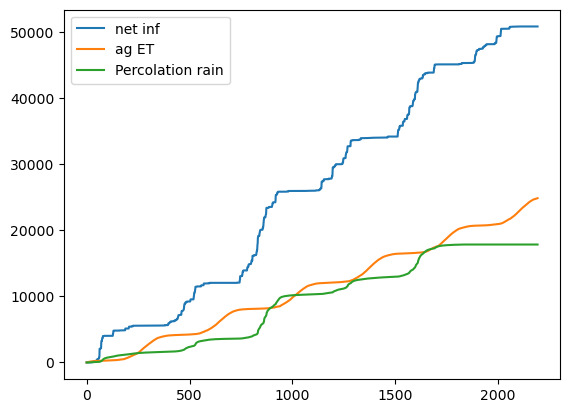

In [133]:
plt.plot(net_inf.sum(axis=(1,2)).cumsum(), label='net inf')
plt.plot(agETc.sum(axis=(1,2)).cumsum(),label='ag ET')
# plt.plot(natETc.sum(axis=(1,2)).cumsum(),label='native ET')

plt.plot(perc.sum(axis=(1,2)).cumsum(), label='Percolation rain')

plt.legend()
# 

In [134]:
# have transient recharge start after the 1st spd

# rech_spd = { (j): net_inf[j-time_tr0,:,:] for j in np.arange(time_tr0,nper)}
rech_spd = { (j): perc[j-time_tr0,:,:] for j in np.arange(time_tr0,nper)}


if ss_bool == True:
    rech_spd[0] = ss_perc  

In [135]:
# nrchop = 3, to highest active cell
rch = flopy.modflow.ModflowRch(model = m, nrchop=3, rech = rech_spd, ipakcb=55)

In [136]:
# rch.write_file()

## Well Package
Any input files that are saved externally as a csv should be kept as 1 based row,column but once they are loaded into python it is acceptable to maintain them as zero based.

In [137]:
wel_dir = join(gwfm_dir,'WEL_data')

In [138]:
wells = pd.read_csv(wel_dir+'/all_wells_type.csv')
wells_grid = gpd.GeoDataFrame(wells, geometry = gpd.points_from_xy(wells.easting,wells.northing), crs = 'epsg:32610')
# remove wells that didn't exist before model start date, could improve later to start pumping mid-model
wells_grid.DateWorkEnded = pd.to_datetime(wells_grid.DateWorkEnded )
wells_grid['well_age_days'] = (strt_date - wells_grid.DateWorkEnded).dt.days

# if wells_grid.row.min()==1:
# new version, keep 1 based wells grid, add new columns to do 0 based
wells_grid.row = (wells_grid.row-1).astype(int)
wells_grid.column = (wells_grid.column -1).astype(int)

wells_grid['depth_m'] = wells_grid.TotalCompletedDepth*0.3048
wells_grid['flux'] = 0
wells_grid['layer'] = 0

In [139]:
ag_well_depth_arr = np.loadtxt(wel_dir+'/ag_well_depth_arr.tsv', delimiter='\t')

### Calculate layers for Ag wells then public/domestic
Dependent on m.dis.botm

In [140]:
ag_screen_botm = np.where(dem_data-ag_well_depth_arr<topbotm)
ag_screen_botm = np.rot90(np.vstack(ag_screen_botm))
ag_screen_botm = pd.DataFrame(ag_screen_botm, columns=['layer','row','column'])
ag_max_lay = ag_screen_botm.groupby(['row','column']).max()
# any wells below most bottom go in bottom layer
ag_max_lay.layer[ag_max_lay.layer == nlay] = nlay-1

# assume 10% of well is screened? Pauloo? tprogs lay thickness is 4m, so 12ft, not quite enough for typical well?
# if we go two layers we have 8 m which is near the average expected well screen
ag_screen_top = np.where((dem_data-ag_well_depth_arr*0.9)<topbotm)
ag_screen_top = np.rot90(np.vstack(ag_screen_top))
ag_screen_top = pd.DataFrame(ag_screen_top, columns=['layer','row','column'])
ag_min_lay = ag_screen_top.groupby(['row','column']).max()
ag_min_lay.layer[ag_min_lay.layer == nlay] = nlay-1


In [141]:
wel_bot_elev = dem_data[wells_grid.row, wells_grid.column] - wells_grid.depth_m
wells_grid['layer'] = get_layer_from_elev(wel_bot_elev, botm[:,wells_grid.row, wells_grid.column], m.dis.nlay)

In [142]:
print('Cells with wells: ', wells_grid.dissolve(by='node',aggfunc='first').shape[0], 'total wells: ', wells_grid.shape[0])
print('Wells with TRS accuracy: ', (wells_grid.MethodofDeterminationLL == 'Derived from TRS').sum())

wells_grid_notrs = wells_grid.loc[wells_grid.MethodofDeterminationLL != 'Derived from TRS']

Cells with wells:  1380 total wells:  2482
Wells with TRS accuracy:  823


In [143]:
# already filtering by land type above
ET_ag = np.copy(agETc)
# remove ET_ag that causes pumping depression in foothills that isn't backed by head data
# with the irrigation based ET method there is no pumping placed in the foothills so this barely reduces pumping
# not needed after updating crop maps
# ET_ag = ET_ag*(~deep_geology[0,:,:])

if ss_bool == True:
    ET_ag_SS = np.reshape(ss_agETc.mean(axis=0),(1, nrow,ncol))
    ET_ag = np.concatenate((ET_ag_SS, ET_ag), axis=0)

In [144]:
# assume each public supply well serves 5-10,000 people each needing 50 gpd, then need to convert to ft^3
public_flux = (5000*50/7.48)*(0.3048**3)
# public_flux = 1500*(1/7.48)*(0.3048**3)*60*24

# avg residence with 3 people at 100 gpd would require 300 gpd, gives 1/3 AF/year
# ag-res is likely higher with irrigation needs (lawns, trees), could bump to 1-2AF/year
# dom_flux = 30*(1/7.48)*(0.3048**3)*60*24 # too large
# dom_flux = 100*3*(1/7.48)*(0.3048**3) #  1/3 AF/year
dom_flux = 2*43560*(0.3048**3)/365 #  assume higher 2AF/yr with lots of grass/trees on residential lots

print('Irrig flux:', '%.3e' % (ET_ag.mean(axis=(0)).sum()*200*200), 'Public flux:', '%.3e' %public_flux,'Domestic flux:', '%.3e' %dom_flux)

Irrig flux: 4.537e+05 Public flux: 9.464e+02 Domestic flux: 6.759e+00


In [145]:
# define pumping rate based on well use, average pumping rate in m^3/day
# wells_grid.loc[wells_grid.Simple_type == 'irrigation', 'flux'] = -irrig_flux
wells_grid.loc[wells_grid.Simple_type == 'domestic', 'flux'] = -dom_flux
wells_grid.loc[wells_grid.Simple_type == 'public', 'flux'] = -public_flux

In [148]:
# load prepared daily domestic use data
dom_use = pd.read_csv(join(wel_dir, 'domestic_water_use.csv'), index_col=0, parse_dates=True)
dom_use = dom_use[strt_date:end_date]
# load data of locations of domestic wells
dom_loc = pd.read_csv(join(wel_dir, 'ag_res_parcel_domestic_wells.csv'), index_col=0)
# make row,column 0 based
dom_loc.row = (dom_loc.row-1).astype(int)
dom_loc.column = (dom_loc.column -1).astype(int)
# get domestic well layers
dom_wel_bot = (dem_data[dom_loc.row, dom_loc.column]- dom_loc.fill_depth_m).values
dom_loc['layer'] = get_layer_from_elev(dom_wel_bot, botm[:,dom_loc.row, dom_loc.column], m.dis.nlay)

In [149]:
# dom_grid = grid_p.set_index(['row','column']).loc[list(zip(dom_loc.row+1, dom_loc.column+1))]
dom_grid = grid_p.merge(dom_loc,on=['row','column'])

In [151]:
# pull out public wells for input
wells_public = wells_grid[wells_grid.Simple_type=='public'][['layer','row','column', 'flux']]

In [156]:

# for each stress period specify the flux of parcels from the expected domestic well flux time series
# multiply by scaling factor based on parcel size
dom_loc['flux'] = -dom_use.flux_m3d.mean()*dom_loc.used_area_acres
# dom_loc['flux'] = - dom_use.loc[t,'flux_m3d']
wells_dom = dom_loc[['layer','row','column','flux']].values
spd_noag = np.vstack((wells_dom, wells_public))

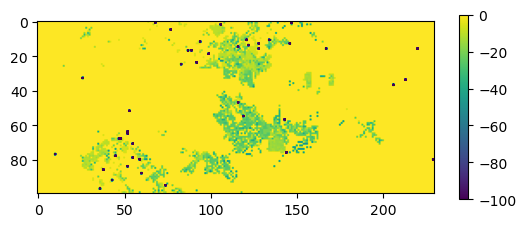

In [157]:
temp = np.zeros((nrow,ncol))
temp[spd_noag[:,1].astype(int), spd_noag[:,2].astype(int)] = spd_noag[:,3]
plt.imshow(temp, vmin=-100)
plt.colorbar(shrink=0.5)

Add pumping from fish farms and other small water surfaces on the south side of the cosumnes that are filled with groundwater use.

In [158]:
# the coefficient for open water is 1.2 at all times
ET_water = ETo_m[strt_date:end_date]*1.2

In [159]:
water_surf = gpd.read_file(join(uzf_dir,'county_landuse','ag_lu_locally_defined.shp'))
water_surf = gpd.overlay(water_surf, grid_p)
water_surf['area_m2'] = water_surf.geometry.area
# make row,column 0 based
water_surf.row = (water_surf.row-1).astype(int)
water_surf.column = (water_surf.column -1).astype(int)

In [160]:
water_surf['depth_m'] = ag_well_depth_arr[water_surf.row, water_surf.column]
wel_bot_elev = dem_data[water_surf.row, water_surf.column] - water_surf.depth_m
water_surf['layer'] = get_layer_from_elev(wel_bot_elev, botm[:,water_surf.row, water_surf.column], m.dis.nlay)

In [161]:
# for each stress period specify the flux of water surfaces 
water_surf['flux'] = -ET_water.mean()*water_surf.area_m2
wells_ws = water_surf[['layer','row','column','flux']].values
spd_noag = np.vstack((wells_dom, wells_public, wells_ws))

In [162]:
# save domestic, public wells for their pumping doesn't depend on ET
# wells_grid_no_ag = wells_grid.loc[wells_grid.Simple_type != 'irrigation']
# # remove wells older than 40 years for ag-residential (no impact), let's keep this now
# # 500 wells are removed with 30 year age, 1500 remain. 
# wells_grid_no_ag = wells_grid_no_ag[wells_grid_no_ag.well_age_days < 40*365]

# # aggregate wells for each row,column to reduce number of times an input is needed
# no_ag_sum = wells_grid_no_ag.groupby(['layer','row','column']).sum(numeric_only=True)[['flux']].reset_index()

# # filter out data for wel package
# spd_noag = no_ag_sum.loc[:,['layer','row','column', 'flux']].values


In [163]:
lu_ag = gpd.read_file(join(uzf_dir, 'county_landuse', 'domain_ag_lu_2018.shp'))
lu_ag = gpd.overlay(lu_ag, grid_p)

#### Using ETc in all cells for pumping

In [164]:
# ag_max_lay = ag_min_lay+1

# iterate over all row, col and get layers for each well based on "screen" 
ag_well_lay = np.zeros((1,3))
for i,j in zip(ag_min_lay.reset_index().row,ag_min_lay.reset_index().column):
    lays = np.arange(ag_min_lay.layer.loc[i,j],ag_max_lay.layer.loc[i,j]+1)
    ijk = np.rot90(np.vstack((np.tile(i,len(lays)), np.tile(j,len(lays)),lays)))
    ag_well_lay = np.vstack((ag_well_lay,ijk))
# delete filler first row
ag_well_lay = ag_well_lay[1:]
ag_well_lay = pd.DataFrame(ag_well_lay.astype(int), columns=['row','column','layer'])

In [165]:
num_ag_layers = (ag_max_lay - ag_min_lay+1).reset_index()
# divide ET_ag by the number of layers it will go into
ET_ag_layered = np.copy(ET_ag)
ET_ag_layered[:,num_ag_layers.row,num_ag_layers.column] /= num_ag_layers.layer.values
# adjustments to allow connection with rows,cols with pumping
row_col = ag_well_lay.loc[:,['row','column']].rename({'row':'rowi','column':'colj'},axis=1)
ag_well_lay = ag_well_lay.set_index(['row','column'])
ag_well_lay['rowi'] = row_col.rowi.values
ag_well_lay['colj'] = row_col.colj.values

In [166]:
# plt.imshow(ET_ag_layered.mean(axis=0))
# plt.colorbar()

In [167]:
m3_AF = 1/(0.3048**3)/43560

In [168]:
# check ag pumping 
# pump_check = pd.DataFrame(-ET_ag[1:].sum(axis=(1,2))*200*200,columns=['Ag_pump_m3_day'])
# pump_check['Date'] = pd.date_range(strt_date, end_date)
# pump_check['domestic_m3_day'] = wells_grid_no_ag[wells_grid_no_ag.Simple_type =='domestic'].flux.sum()
# pump_check['public_m3_day'] = wells_grid_no_ag[wells_grid_no_ag.Simple_type =='public'].flux.sum()
# pump_check = pump_check.set_index('Date')
# pump_check.resample('AS-Oct').sum()*m3_AF

In [173]:
# layer for ETc ag well pumping
# ETc_lay = 1
# create empty dictionary to fill with stress period data
wel_ETc_dict = {}
# end date is not included as a stress period, starting at 1st TR spd (2)
for t in np.arange(0,nper):
    wel_i, wel_j = np.where(ET_ag[t, :, :]>0)
    new_xyz = ag_well_lay.loc[list(zip(wel_i,wel_j))] 
#     wel_ETc = -ET_ag[t-1,wel_i,wel_j]*delr*delr
# use new row,cols because there are more layers to use
    wel_ETc = -ET_ag_layered[t, new_xyz.rowi, new_xyz.colj]*delr*delr
    # ['layer','row','column', 'flux'] are necessary for WEL package
    spd_ag = np.stack((new_xyz.layer, new_xyz.rowi, new_xyz.colj,wel_ETc),axis=1)
    # correct by dropping any rows or cols without pumping as some may be added
    spd_ag = spd_ag[spd_ag[:,-1]!=0,:]
    # for each stress period specify the flux of parcels from the expected domestic well flux time series
    dom_loc['flux'] = - dom_use.loc[dates[t],'flux_m3d']*dom_loc.used_area_acres
    wells_dom = dom_loc[['layer','row','column','flux']].values
    # for each stress period specify the flux of water surfaces 
    water_surf['flux'] = -ET_water.loc[dates[t],'Fair Oaks']*water_surf.area_m2
    wells_ws = water_surf[['layer','row','column','flux']].values
    spd_noag = np.vstack((wells_dom, wells_public, wells_ws))
#     spd_noag = np.vstack((wells_dom, wells_public))
    # join pumping from ag with point pumping from domstic/supply wells that are constant
    spd_all = np.vstack((spd_ag,spd_noag)) 
    wel_ETc_dict[t] = spd_all

In [171]:
# wel_chk = np.zeros(nper)
# for t in np.arange(0,nper):
#     wel_chk[t] = wel_ETc_dict[t][:,3].sum()
    
# (wel_chk.mean(axis=0)*(1/0.3048**3))/43560

In [172]:
# still a few wells in foothills that might be causing the drawdown, but more localized now
# test = np.zeros((nlay,nrow,ncol))
# test[spd_noag[:,0].astype(int),spd_noag[:,1].astype(int),spd_noag[:,2].astype(int)]=spd_noag[:,3]
# plt.imshow(test.sum(axis=0))

In [174]:
# Create well flopy object
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_ETc_dict,ipakcb=55)

In [175]:
wel.write_file()
# wel.check()

In [177]:
# convert pumping to array
pump = np.zeros((m.dis.nper,m.dis.nrow,m.dis.ncol))
for n in np.arange(0,m.dis.nper):
    wel_n = m.wel.stress_period_data[n]
    pump[n, wel_n.i, wel_n.j] += wel_n.flux*-1
pump_rate = pump/(m.dis.delr[0]*m.dis.delc[0])


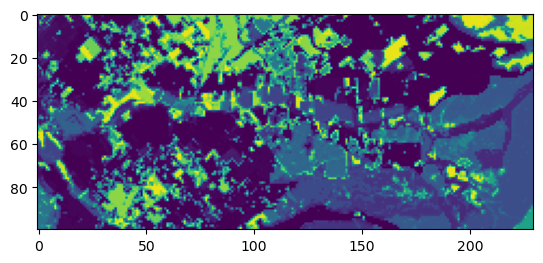

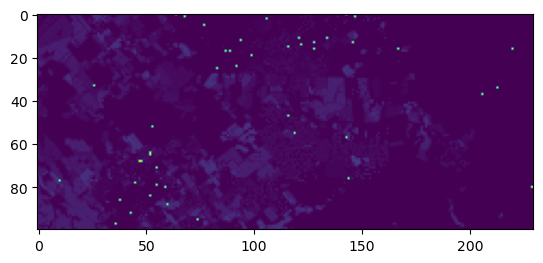

In [200]:
n=4
plt.imshow(perc[1+365*n:1+365*(n+1)].sum(axis=0))
plt.show()
plt.imshow(pump_rate[1+365*n:1+365*(n+1)].sum(axis=0))
plt.show()

## HOB Package

In [364]:
hob_dir = gwfm_dir+'/HOB_data'

In [365]:
# load cleaned data from box data, lengths are in meters
all_obs = pd.read_csv(hob_dir+'/all_obs_grid_prepared.csv',index_col='date', parse_dates=True)
# all_obs = pd.read_csv(hob_dir+'/all_obs_grid_prepared_auto_QAQC.csv',index_col='date', parse_dates=True)

# all_obs = all_obs.set_index('dt')
all_obs = all_obs.loc[(all_obs.index>strt_date)&(all_obs.index<end_date)]

# # # get spd corresponding to dates
all_obs['spd'] = (all_obs.index-strt_date).days.values


In [366]:
# any well with less than 2 measurements per year the period should not be used
# difference between 2 and 4 measurements dropped is only 3 more wells so conservative is better
hob_min = int(2*nper/365)-2
# wells to be used in calibration
hob_use = all_obs.site_code.unique()[(all_obs.groupby('site_code').count()>hob_min)["gwe"].values]
print('Number of wells droppped', all_obs[~all_obs.site_code.isin(hob_use)].site_code.unique().shape[0])
print('Number of wells kept',all_obs[all_obs.site_code.isin(hob_use)].site_code.unique().shape[0])

all_obs = all_obs[all_obs.site_code.isin(hob_use)]

Number of wells droppped 13
Number of wells kept 57


In [367]:
if all_obs.avg_screen_depth.isna().sum()>0:
    print('Some OBS missing screen depth')

all_obs['screen_elev'] = dem_data[all_obs.row-1, all_obs.column-1] - all_obs.avg_screen_depth
# keep 1 based layer
all_obs['layer'] = get_layer_from_elev(all_obs.screen_elev, botm[:,all_obs.row-1, all_obs.column-1], m.dis.nlay) + 1

<Axes: >

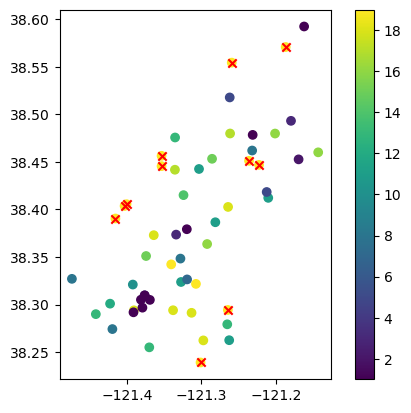

In [368]:
stns = all_obs.drop_duplicates('site_code', keep='last').reset_index().drop(columns=['date','gwe'])
stns = gpd.GeoDataFrame(stns, geometry = gpd.points_from_xy(stns.longitude, stns.latitude),crs='epsg:4326')
stns['botm_elev'] = botm[stns.layer-1, stns.row-1, stns.column-1]
fig,ax = plt.subplots()
stns.plot('layer',legend=True,ax=ax)
# wells below the model bottom
stns[stns.botm_elev > stns.screen_elev].plot(color='red',marker='x',ax=ax)

In [369]:
# save cleaned data to input data for post-processing
all_obs.to_csv(model_ws+'/input_data/all_obs_grid_prepared.csv')

In [370]:
dwr_site_codes = all_obs.site_code.unique()

# create a new hob object
obs_data = []
dwr_spd_wse = all_obs.loc[:,['site_code','spd','gwe']]
for i in np.arange(0,len(dwr_site_codes)): # for each well location
    # time_series_data needs stress period in col 0 and WSE in col 1
    # the row and column are already one based as they come from grid_p
    # need to return and adjust layer later, for now layer 2 should be good so that it doesn't go dry
    # get stress period data and water surface elevation for well
    dwr_site = all_obs.set_index('site_code').loc[dwr_site_codes[i]]
    if dwr_site.ndim >1:
        row = dwr_site.row.values[0]
        col = dwr_site.column.values[0]
        layer = dwr_site.layer.values[0]
        names = dwr_site.obs_nam.tolist()
        obsname = 'N'+str(dwr_site.node.values[0])
    else:
        row = dwr_site.row
        col = dwr_site.column
        layer = dwr_site.layer
        names = dwr_site.obs_nam
        obsname = 'N'+str(dwr_site.node)
        
    tsd = dwr_spd_wse.set_index('site_code').loc[dwr_site_codes[i]].values
    # need to minus 1 for grid_p which is 1 based
    temp = flopy.modflow.HeadObservation(m, layer=layer-1, row=row-1, 
                                                  column=col-1,
                                                  time_series_data=tsd,
                                                  obsname=obsname, names = names)
    # correct time offset from stress period to be 0
    temp.time_series_data['toffset'] = 0
    obs_data.append(temp)


In [371]:
hob = flopy.modflow.ModflowHob(m, iuhobsv=50, hobdry=-9999., obs_data=obs_data, unitnumber = 39,
                              hobname = 'MF.hob.out')

In [1420]:
# hob.write_file()

In [377]:
wel.write_file()

# Stream Gage outflow

In [1208]:
sensors = pd.read_csv(gwfm_dir+'/Mapping/allsensor_latlong.csv')
sensors = gpd.GeoDataFrame(sensors,geometry=gpd.points_from_xy(sensors.Longitude, sensors.Latitude))
sensors.crs = 'epsg:4326'
sensors = sensors.to_crs('epsg:32610')
mcc_grid = gpd.sjoin(sensors[sensors.Site_id=='MCC'],xs_sfr)
mcc_grid.columns

Index(['Sensor_type', 'Group', 'Site_id', 'Logger_name', 'Latitude',
       'Longitude', 'Elev_m_MSL', 'geometry', 'index_right', 'node', 'row',
       'column', 'index_righ', 'z', 'easting', 'northing', 'slope',
       'Point_orde', 'length_m', 'z_min', 'dist_m', 'iseg', 'reach_new'],
      dtype='object')

In [1421]:
# numgage is total number of gages
# gage_data (list, or array), includes 2 to 3 entries (LAKE -UNIT (OUTTYPE)) for each LAK entry
#  4 entries (GAGESEG, GAGERCH, UNIT, OUTTYPE) for each SFR package entry

mcc_gage_data = [[mcc_grid.iseg, mcc_grid.reach_new, 37, 1]]
gage_file = 'MF.gage'
mcc_file_out = 'MF_mcc.go' # not recognized still
gag = flopy.modflow.ModflowGage(model=m,numgage= 1,gage_data=mcc_gage_data,
                                filenames =[gage_file,mcc_file_out])


In [259]:
# gag.write_file()
# m.write_name_file()

## Output Control

In [1422]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# get the first of each month to print the budget
month_intervals = (pd.date_range(strt_date,end_date, freq="MS")-strt_date).days
spd = {}
# output file for parallel runs when head/cbc is not needed
for j in month_intervals:
    spd[j,0] = ['print budget']
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True, filenames='MF_parallel.oc')
oc.write_file()


# For later model runs when all the data is needed to be saved
spd = {}
spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper,1)}

for j in month_intervals:
    spd[j, 0] = ['save head', 'save budget','print budget']
    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

## Newton Solver

In [1423]:
nwt = flopy.modflow.ModflowNwt(model = m, headtol=1E-4, fluxtol=500, maxiterout=200, thickfact=1e-05, 
                               linmeth=1, iprnwt=1, ibotav=0, options='Specified', Continue = True)
nwt_dict = nwt.__dict__

# load in parameters used by margaret shanafield for DFW
nwt_ex = pd.read_csv(gwfm_dir+'/Solvers/nwt_solver_input_from_dfw.csv', comment='#')
nwt_ex['nwt_vars'] = nwt_ex.NWT_setting.str.lower()
nwt_ex = nwt_ex.set_index('nwt_vars')
nwt_ex = nwt_ex.dropna(axis=1, how='all')
# nwt_ex.select_dtypes([float, int])

for v in nwt_ex.index.values:
    nwt_dict[v] = nwt_ex.loc[v,'Second'].astype(nwt_ex.loc[v,'nwt_dtype'])
    
# correct fluxtol for model units of m3/day instead of m3/second
nwt_dict['fluxtol'] = 500 
    # update NWT sovler parameters
nwt.__dict__ = nwt_dict

nwt.write_file()

In [ ]:

# thickfact: portion of cell thickness used for smoothly adjusting storage and conductance coefficients to zero (default is 1e-5)
# linmeth (linear method): 1 for GMRES and 2 for XMD (1 is default)
# iprnwt: flag whether additional info about solver convergence will be printed to the main listing file (default is 0)
# ibotav: flag whether corretion will be made to gw head relative to cell-bottom if surrounded by dry cells.
# 1 = corrections and  0 = no correction (default is 0)
# options: specify comlexity of solver. SIMPLE : default solver for linear models, MODERATE for moderately nonlinear models,
# COMPLEX for highly nonlinear models (default is COMPLEX)
# Continue: if model fails to converge during a time step it will continue to solve the next time step (default is False) 
# epsrn (XMD) is the drop tolerance for preconditioning (default is 1E-4)
# hclosexmd (XMD) head closure criteria for inner (linear) iterations (default 1e-4)



In [212]:
max_outer = 200
max_inner = 100
hclose = 1e-02
fluxtol = 500
rclose=1e-01


# iter_mo max outer iters, ter_mi = max inner iters, close_r residual criterion for stopping iteration
# close_h is alternate criterion for nonlinear problem, and is head closure which should be smaller than residual closer
# ipunit =0 means no info on solver, ipunit=1 means output about solver issues is written
# if iter_mo >1 then closer_r is used not close_h and closer_r is compared to 
# the square root of the inner product of the residuals (the residual norm)
# adamp =0 is std damping, adamp=1 is adaptive damping that further decreases or increases damping based on picard
# iteration sucess
#adamp is 0.7 to resolve issues with heads oscillating near solution +1 m
# damp_lb = lower bound, rate_d is rate of increase of damping based picard iteration success

# from SVIHM, if you rewrite the solver parameters in NWT it can change between stress periods
# solver = flopy.modflow.ModflowPcgn(m, iter_mo = max_outer, iter_mi=max_inner, close_r=rclose, close_h=hclose, ipunit=28) 
#                                 relax = 0.99, ifill=1)
#                                adamp=1, damp=0.7, damp_lb=0.1, rate_d=0.01)



In [ ]:
# solver.write_file()

In [268]:
m.model_ws

'F:/WRDAPP/GWFlowModel/Cosumnes/Regional/historical_simple_geology'

In [1212]:
m.get_package_list()
# m.remove_package('DATA')
# m.remove_package('LAK')
# m.remove_package('WEL')
# m.remove_package('RCH')
# m.remove_package('NWT')

['DIS',
 'BAS6',
 'UPW',
 'SFR',
 'DATA',
 'GHB',
 'CHD',
 'RCH',
 'HOB',
 'GAGE',
 'OC',
 'NWT']

In [267]:

m.check()
# lak.check()
# upw.check()


MF MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 1743 stress periods

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF package: vertical hyd

## Write the input files

In [ ]:
# save modflow workspace file to WRDAPP sub folder to improve runtime calculations
# loadpth = 'F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/streamflow/'
# # load model with only DIS to reduce load time
# # the model will run off of the .nam file connection so flopy doesn't need them
# all_model_ws = loadpth + '/historical_streamflow'


# load_only = ['CHD', 'SFR','PCGN','OC','BAS6','DIS'] # avoid loading packages that are entirely re-written
# # in the case this runs in the basefolder then the current working directory
# # is the same as the all working directory - useful now with weird naming between realizations
# # if basename(model_ws).__contains__('historical'):
# #     all_model_ws = model_ws
# m2 = flopy.modflow.Modflow.load('MF.nam', model_ws=all_model_ws, 
#                                 exe_name='mf-owhm.exe', version='mfnwt')

In [1213]:
# Writing the MODFLOW data files
m.write_input()


# Model notes
Maybe due to model complexity I should simplify model to 3 layers for inital calibration and then run individual sensitivity analysis rather than calibration looking at gwe data for SOSWR then streamflow data.
I should check at least a couple other realizations to check fit
Need to add streamflow calibration data for McConnell.

Big question: is the drawdown in the basin primarily due to internal groundwater pumping from agriculture and domestic wells or from external outflow. I may need to increase the outflow to the GHB to bring down water levels in the basin. Jan used simulated gw head 1000 m from the model edge and the arithmetic mean of the regional flow model hk

I should also return to look at whether the nwt solver will work and then look at unconfined simulation. Jan only simulated the top layer as unconfined to represent the water table.

Sy is only read for converitble layers (LAYTYP != 0)
Ss is specific storage unless STORAGECOEFFICIENT is used then it is the confined storage coefficient
Sand/Gravel hk> ~100

Running one parallel run took about 44 minutes but no major issues so i'm unsure why the parallel calibration failed
First forward run took about 47 minutes as well still using PCGN (hits mxiter 33 times mbe = 0.00, mxiter=200), try switching to NWT and playing with run time
NWT solver takes 1 hr 46 minutes and hits mxiter 11 times (mxiter=500), mbe = 0.00% with COMPLEX setting.
NWT solver with MODERATE takes 1 hr 39 minutes mxiter 11 times (mxiter=300), mb = 0.02
Using base NWT settings it is slower than PCGN

# UCODE Input

In [605]:
# pgroup = pd.read_csv(model_ws+'/MF_ucode.pgroup', delimiter=r'\s+', index_col='GroupName',
#                      skipfooter=1, skiprows=2, engine='python')
# pgroup.loc['GHB','Adjustable']
# pgroup.index
# # if pgroup.loc['UZF','Adjustable'] =='yes':
# #     print('True')

## Format parameter data (pdata) file

In [240]:
def get_magnitude(x):
    return(10.0**(np.log10(x).astype(int)))


# melt parameter data and rename columns to fit UCODE format for .pdata
pdata = params.rename(columns={'K_m_d':'Kx'})[['Kx','vani','Ss','Sy']]
pdata = pdata.melt(ignore_index=False)
pdata['ParamName'] = pdata.variable + '_' + pdata.index.astype(str)
pdata = pdata.rename(columns={'variable':'GroupName','value':'StartValue'}).reset_index(drop=True)
# join scaling factors to hydraulic parameters
pdata = pdata.append(scaling_factors_all)

# default values for pdata input
pdata['LowerValue'] = 1E-38
pdata['UpperValue'] = 1E38

# local adjustment based on typical parameter scaling (start value scaled by a range)
# need to find a better rounding function
grps = pdata.GroupName.isin(['Kx','Ss','vani','GHB'])
pdata.loc[grps,'LowerValue'] = get_magnitude(pdata.loc[grps,'StartValue']) *1E-3
pdata.loc[grps,'UpperValue'] = get_magnitude(pdata.loc[grps,'StartValue']) *1E3
grps = pdata.GroupName.isin(['Sy'])
pdata.loc[grps,'LowerValue'] = get_magnitude(pdata.loc[grps,'StartValue']) *1E-2
pdata.loc[grps,'UpperValue'] = 1
grps = pdata.ParamName.str.contains('rch_')
pdata.loc[grps,'LowerValue'] = get_magnitude(pdata.loc[grps,'StartValue']) *1E-3
pdata.loc[grps,'UpperValue'] = 2

# assume constraints align with expected range
pdata['Constrain'] = 'No'
pdata['LowerConstraint'] = pdata.LowerValue
pdata['UpperConstraint'] = pdata.UpperValue



In [252]:
# pdata.ParamName.str.contains('rch_')
# pdata.ParamName.isin([r'rch_.'])


## JTF files

In [310]:
# Write out jtf file
p_out = params.drop(columns=['K_m_d'])
p_out.K_m_s = '@'+('Kx_'+p_out.index.astype(str)).str.ljust(20)+'@'
# p_out.vani = '@'+('vani_'+p_out.index.astype(str)).str.ljust(20)+'@'
p_out.Sy = '@'+('Sy_'+p_out.index.astype(str)).str.ljust(20)+'@'
p_out.Ss = '@'+('Ss_'+p_out.index.astype(str)).str.ljust(20)+'@'

with open(model_ws+'/ZonePropertiesInitial.csv.jtf', 'w',newline='') as f:
    f.write('jtf @\n')
    p_out.to_csv(f,index=True, mode="a")
    
scaling_jtf = scaling_factors_all.copy()
# Write out jtf file
scaling_jtf.StartValue = '@'+scaling_jtf.ParamName.str.ljust(20)+'@'

with open(model_ws+'/GHB_UZF_WEL_scaling.csv.jtf', 'w',newline='') as f:
    f.write('jtf @\n')
    scaling_jtf.to_csv(f,index=False, mode="a")

## Observation data

In [311]:
ucode_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/ucode_utilities'
if ucode_fxn_dir not in sys.path:
    sys.path.append(ucode_fxn_dir)
# sys.path
import ucode_input

from importlib import reload
# importlib.reload
reload(ucode_input)

<module 'ucode_input' from 'C:\\Users\\ajcalder\\Documents/GitHub/CosumnesRiverRecharge/ucode_utilities\\ucode_input.py'>

In [312]:
hobout = pd.read_csv(m.model_ws+'/MF.hob.out',delimiter = r'\s+')

# here std deviation represents the actual value one expects
# for a well the accuracy is 0.01 ft at best based on measuring tape scale
all_obs['Statistic'] = 0.01
all_obs['StatFlag'] = 'SD'
# locations with significant difference between RPE GSE and the DEM should have additional uncertainty included
all_obs['Statistic'] += np.round(np.abs(all_obs.dem_wlm_gse),4)

hobout_in = hobout.join(all_obs.set_index('obs_nam')[['Statistic','StatFlag']],on=['OBSERVATION NAME'])
# temporary fix for misjoin for single observation HOB nodes
hobout_in.loc[hobout_in.Statistic.isna(),'Statistic'] = 0.01 
hobout_in['StatFlag'] = 'SD'

ucode_input.write_hob_jif_dat(model_ws, hobout_in, statflag=True)

In [313]:
sfr_dir = gwfm_dir+'/SFR_data/'

In [314]:
# data for obs table
mcc_d = pd.read_csv(sfr_dir+'MCC_flow_obs_all.csv', index_col='DATE TIME', parse_dates=True)

mcc_d = mcc_d[(mcc_d.index>=strt_date)&(mcc_d.index<=end_date)]
# ObsName ObsValue Statistic StatFlag GroupName
mcc_d['ObsName'] = ('mcc_'+pd.Series(np.arange(0,len(mcc_d)).astype(str)).str.zfill(5)).values
# make sure units are flow in m^3/day
mcc_d = mcc_d.rename(columns={'flow_cmd':'ObsValue'})

cols_out = ['ObsName','ObsValue','Statistic','StatFlag','GroupName']

header = 'BEGIN Observation_Data Table\n'+\
    'NROW= '+str(len(mcc_d))+' NCOL= 5 COLUMNLABELS\n'+\
    ' '.join(cols_out)

footer = 'End Observation_Data'
# get array of just strings
flow_arr = mcc_d[cols_out].values
# pull out observed value and name of obs
np.savetxt(model_ws+'/flow_obs_table.dat', flow_arr,
           fmt='%s', header = header, footer = footer, comments = '' )

# for gage file JIFs need to specify which flows are used by specify the observation name
# for the correct row (time) and filling the rest with a dummy variable (Cab used dum)

In [317]:
gagenam = model_ws+'/MF_mcc.go'
gage = pd.read_csv(gagenam,skiprows=1, delimiter = r'\s+', engine='python')
# clean issue with column name read in
cols = gage.columns[1:]
gage = gage.dropna(axis=1)
gage.columns = cols
# set datetime for joining with flow obs data
gage['dt'] = strt_date + (gage.Time-1).astype('timedelta64[D]')
gage = gage.set_index('dt').resample('D').mean()
gage_jif = gage[['Time','Flow']].join(mcc_d)
# if I leave Nan values then ucode gets upset, Cab used the filler dum which I think Ucode identifies
gage_jif.loc[gage_jif.ObsName.isna(),'ObsName'] = 'dum'

In [318]:
# def write_flw_jif(model_ws, gagout):
#     # skip 2 rows, use 3rd column values for 1345 values for std MF gage out file
header = 'jif @\nStandardFile 2 3 '+str(len(gage_jif))
# header = 'jif @\n'+'StandardFile  1  1  '+str(len(obsoutnames))
# obsoutnames.to_file(m.model_ws+'/MF.hob.out.jif', delimiter = '\s+', index = )
np.savetxt(model_ws+'/MF_mcc.go.jif', gage_jif.ObsName.values,
           fmt='%s', delimiter = r'\s+',header = header, comments = '')

## Parallel ucode

In [319]:
n_nodes = ucode_input.get_n_nodes(13)

In [320]:
# 2400 seconds is about 40 minutes which is avg run time
# may need to extend upward to 3 hours (10800) for slow runs
ucode_input.write_parallel(model_ws, n_nodes,2400) 

In [321]:
# copy mf files except cbc and hds
mf_files = pd.Series(glob.glob(m.model_ws+'/MF.*'))
mf_files = mf_files[~mf_files.str.contains('cbc|hds').values].tolist()
jtfs = glob.glob(m.model_ws+'/*.jtf')
run = glob.glob(m.model_ws+'/*py*')

files = mf_files+jtfs+run
# files = glob.glob(m.model_ws+'/*.jtf')

In [229]:
# when dealing with larger data sets, it may be worthwhile using parallel subprocess
import shutil, os


for n in np.arange(0, n_nodes).astype(str):
    folder = '/r'+ n.zfill(3)+'/'
    os.makedirs(m.model_ws+folder,exist_ok=True)
    for f in files:
        shutil.copy(f, m.model_ws+folder)

In [227]:
# replace oc file with simplified version that only prints the budget monthly
f = glob.glob(m.model_ws+'/MF_parallel.oc')[0]

for n in np.arange(0, n_nodes).astype(str):
    folder = '/r'+ n.zfill(3)+'/'
    os.makedirs(m.model_ws+folder,exist_ok=True)
    shutil.copy(f, m.model_ws+folder+'/MF.oc')

In [613]:
import shutil, os

# write out just the updated python write file
write_file = glob.glob(model_ws+'/*.py')
for n in np.arange(0,n_nodes).astype(str):
    folder = '/r'+ n.zfill(3)
    shutil.copy(write_file[0], model_ws+folder)